# Deep Learning Challenge - Training
## Michelle Rohrer

Dieses Notebook enthält alle Trainings.

### Pakete laden

In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pydantic')

# Dann der Rest Ihrer Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import wandb
from dotenv import load_dotenv
import pickle
import gc

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import multiprocessing

from src.plots import (
    plot_training_curves,
    plot_hyperparameter_comparison,
    plot_hyperparameter_performance_summary,
    plot_experiment_comparison,
    plot_model_complexity_analysis,
    plot_training_curves_comparison
)
from src.model import BaselineCNN, FlexibleCNN, create_deeper_model, create_wider_model, create_model_with_fc_width
from src.test_train import (
    train_model,
    hyperparameter_tuning_with_wandb
)
from src.evaluation import (
    cross_validation_training
)
from src.experiments import run_hyperparameter_experiment, save_experiment_results, save_hypothesis_results, load_hypothesis_results
from setup_config import get_device, get_optimal_num_workers, should_use_pin_memory

load_dotenv()
wandb_key = os.getenv('KEY')

if wandb_key:
    print("WanDB Key erfolgreich geladen")
else:
    print("WanDB Key nicht gefunden")


WanDB Key erfolgreich geladen


### Daten laden


In [2]:
base_path = "data"
train_dir = os.path.join(base_path, "train")
test_dir  = os.path.join(base_path, "test")

img_size = 48
batch_size = 32 

# Transformationen
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# train laden
full_train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transform
)

# 80/20 Split für Training/Validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Test-Dataset
test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transform
)

# DataLoader erstellen mit Multi-Core Optimierung
optimal_workers = min(12, get_optimal_num_workers())
print(f"Verwende {optimal_workers} Worker für DataLoader (von {multiprocessing.cpu_count()} Cores)")
print(f"Batch-Größe: {batch_size}")

# pin_memory nur für CUDA aktivieren (nicht für MPS oder CPU)

use_pin_memory = should_use_pin_memory()
if use_pin_memory:
    print("pin_memory aktiviert (CUDA erkannt)")
else:
    print("pin_memory deaktiviert (MPS oder CPU - keine Warnung)")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory  # Nur bei CUDA aktivieren
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory
)

print(f"Klassen: {full_train_dataset.class_to_idx}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Verwende 11 Worker für DataLoader (von 12 Cores)
Batch-Größe: 32
pin_memory aktiviert (CUDA erkannt)
Klassen: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Training samples: 22967
Validation samples: 5742
Test samples: 7178


### Training des Basismodells

**Zweck:** Automatisches Tracking aller Experimente für bessere Reproduzierbarkeit und Analyse.

**Was wird getrackt:**
- **Hyperparameter:** Lernrate, Batch-Größe, Optimizer-Einstellungen
- **Metriken:** Training/Validation Loss und Accuracy pro Epoche
- **Test-Metriken:** Accuracy, Precision, Recall, F1-Score, Top-K Accuracy


In [3]:
# wandb Setup
# wandb API Key aus .env laden
wandb_key = os.getenv('KEY')
if wandb_key:
    wandb.login(key=wandb_key)
    print("wandb erfolgreich authentifiziert")
else:
    print("wandb API Key nicht in .env gefunden")

# Device Setup: MPS (Apple Silicon) > CUDA > CPU
device = get_device()
print(f"Verwende Device: {device}")

# Klassennamen für Evaluation
class_names = list(full_train_dataset.class_to_idx.keys())
num_classes = len(full_train_dataset.class_to_idx)
print(f"Klassen: {class_names}")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Michelle\_netrc
wandb: Currently logged in as: michelle-rohrer (michelle-rohrer-fhnw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb erfolgreich authentifiziert
Verwende Device: cuda
Klassen: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
# Basismodell erstellen und trainieren
print("=== Training des Basismodells ===")

# Modell initialisieren aus Code
# Dies stellt sicher, dass das Modell mit den aktuellen Einstellungen trainiert wird
model = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)

# Sicherstellen, dass models Verzeichnis existiert
os.makedirs('models', exist_ok=True)

# Training durchführen mit wandb
# Das Modell wird automatisch nach Epoche 60 gespeichert (siehe train_model Funktion)
train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s = train_model(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60, 
    learning_rate=0.01,
    batch_size=32,
    use_wandb=True,
    run_name="baseline_model",
    early_stopping=True,
    patience=20,
    min_delta=0.001,
    save_path='models/baseline_model_epoch60.pth'
)

# Finales Modell speichern (nach allen Epochen)
torch.save(model.state_dict(), 'models/baseline_model.pth')
print("Basismodell gespeichert als 'models/baseline_model.pth'")
print(f"Finale Metriken - Accuracy: {val_accs[-1]:.2f}%, F1-Score: {val_f1s[-1]:.4f}")

=== Training des Basismodells ===


Training startet: 60 Epochen, LR=0.01, Batch=32
Early Stopping: patience=20, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8351 | Val Loss: 1.8088 | Train Acc: 24.18% | Val Acc: 25.06% | Patience: 0/20
Epoch   5/60 | Train Loss: 1.7622 | Val Loss: 1.7468 | Train Acc: 27.20% | Val Acc: 27.57% | Patience: 0/20
Epoch  10/60 | Train Loss: 1.6174 | Val Loss: 1.6003 | Train Acc: 37.18% | Val Acc: 38.99% | Patience: 0/20
Epoch  15/60 | Train Loss: 1.5097 | Val Loss: 1.5186 | Train Acc: 41.89% | Val Acc: 40.73% | Patience: 0/20
Epoch  20/60 | Train Loss: 1.4143 | Val Loss: 1.4529 | Train Acc: 45.69% | Val Acc: 42.86% | Patience: 0/20
Epoch  25/60 | Train Loss: 1.3223 | Val Loss: 1.4343 | Train Acc: 49.81% | Val Acc: 44.62% | Patience: 4/20
Epoch  30/60 | Train Loss: 1.2135 | Val Loss: 1.4297 | Train Acc: 54.46% | Val Acc: 44.57% | Patience: 2/20
Epoch  35/60 | Train Loss: 1.0914 | Val Loss: 1.3908 | Train Acc: 59.43% | Val Acc: 47.41%

best_val_loss,███▇▇▆▅▅▅▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▂▂▂▃▃▄▄▅▅▆▆▇▇▇█
train_acc,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_f1,▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁
val_acc,▁▁▁▂▂▄▅▅▄▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇████▇▇███▆▇█▇▆▇
val_f1,▁▁▂▂▃▄▅▅▅▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇█▇▇██▇▇███▇████
val_loss,██▇▇▆▅▅▅▅▄▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▃▂▃▂▄▅▄▆██
best_val_loss,1.37043
epoch,51


Basismodell gespeichert als 'models/baseline_model.pth'
Finale Metriken - Accuracy: 46.46%, F1-Score: 0.4665


In [6]:
# Baseline-Ergebnisse für Experimente konvertieren
# Diese werden in den Hypothesen-Experimenten wiederverwendet, um redundantes Training zu vermeiden

print("=== Konvertiere Baseline-Ergebnisse für Experimente ===")

# Modell erstellen, um Parameter zu zählen (wird nicht trainiert)
baseline_model_for_counting = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)
total_params = sum(p.numel() for p in baseline_model_for_counting.parameters())
trainable_params = sum(p.numel() for p in baseline_model_for_counting.parameters() if p.requires_grad)
del baseline_model_for_counting 

# Beste Performance finden
best_epoch_idx = np.argmax(val_accs)
best_val_acc = val_accs[best_epoch_idx]
best_val_f1 = val_f1s[best_epoch_idx]

# Baseline-Ergebnisse im Format von run_hyperparameter_experiment konvertieren
baseline_results = {
    'experiment_name': 'baseline_model',
    'model_kwargs': {
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64],
        'fc_units': 64
    },
    'num_params': total_params,
    'num_trainable_params': trainable_params,
    'num_epochs_trained': len(train_accs),
    'learning_rate': 0.01,
    'batch_size': 32,
    
    # Trainingskurven
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'train_f1s': train_f1s,
    'val_f1s': val_f1s,
    
    # Finale Metriken
    'final_train_acc': train_accs[-1],
    'final_val_acc': val_accs[-1],
    'final_train_loss': train_losses[-1],
    'final_val_loss': val_losses[-1],
    'final_train_f1': train_f1s[-1],
    'final_val_f1': val_f1s[-1],
    
    # Beste Metriken
    'best_epoch': best_epoch_idx + 1,
    'best_val_acc': best_val_acc,
    'best_val_f1': best_val_f1,
    'best_train_acc': train_accs[best_epoch_idx],
    'best_train_f1': train_f1s[best_epoch_idx],
    
    # Overfitting-Gap
    'overfitting_gap_acc': train_accs[-1] - val_accs[-1],
    'overfitting_gap_f1': train_f1s[-1] - val_f1s[-1],
    
    # Test-Ergebnisse (optional, falls später evaluiert)
    'test_results': None
}

print(f"✓ Baseline-Ergebnisse konvertiert:")
print(f"  - Parameter: {total_params:,}")
print(f"  - Beste Val Acc: {best_val_acc:.2f}% (Epoche {best_epoch_idx + 1})")
print(f"  - Finale Val Acc: {val_accs[-1]:.2f}%")
print(f"  - Diese Ergebnisse werden in den Hypothesen-Experimenten wiederverwendet")

# Baseline-Ergebnisse speichern
os.makedirs('results', exist_ok=True)
save_experiment_results(baseline_results, 'results/baseline_results.json')
print(f"\n✓ Baseline-Ergebnisse gespeichert als 'results/baseline_results.json'")

=== Konvertiere Baseline-Ergebnisse für Experimente ===
✓ Baseline-Ergebnisse konvertiert:
  - Parameter: 171,271
  - Beste Val Acc: 48.87% (Epoche 42)
  - Finale Val Acc: 46.46%
  - Diese Ergebnisse werden in den Hypothesen-Experimenten wiederverwendet
Ergebnisse gespeichert: results/baseline_results.json

✓ Baseline-Ergebnisse gespeichert als 'results/baseline_results.json'


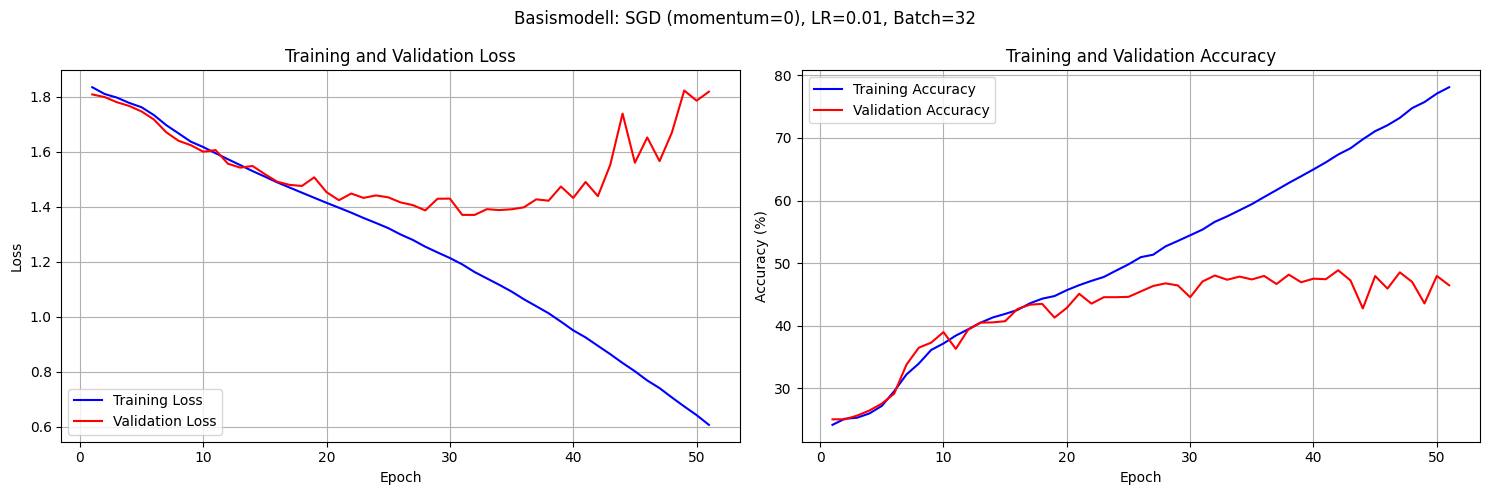

Lernkurven gespeichert als 'plots/baseline_training_curves.png'


In [7]:
# Lernkurven plotten und speichern
# Sicherstellen, dass plots Verzeichnis existiert
os.makedirs('plots', exist_ok=True)

fig = plot_training_curves(train_losses, val_losses, train_accs, val_accs, 
                          title="Basismodell: SGD (momentum=0), LR=0.01, Batch=32")

# Plot als Bild speichern
fig.savefig('plots/baseline_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("Lernkurven gespeichert als 'plots/baseline_training_curves.png'")

### Hyperparameter-Tuning

**Ziel:** Vergleich verschiedener Lernraten und Batch-Größen anhand der Lernkurven und Metriken.

**Testkonfigurationen:**
- **Lernraten:** [0.001, 0.01, 0.1]
- **Batch-Größen:** [16, 32, 64]
- **Epochen:** 60 (konsistent mit Baseline-Training)
- **Optimizer:** SGD ohne Momentum

**Hinweis:** Bei kleinen Datasets wird das Training automatisch beschleunigt.


In [6]:
# Hyperparameter-Tuning mit wandb Integration
print("=== Hyperparameter-Tuning ===")

# Testkonfigurationen
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64] 
num_epochs = 60  # Konsistent mit Baseline-Training (Epoche 60 als Referenz)

# Hyperparameter-Tuning mit wandb durchführen
# Modell-Klasse wird als Parameter übergeben 
results = hyperparameter_tuning_with_wandb(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    model_class=BaselineCNN,  # Modell-Klasse als Parameter
    num_epochs=num_epochs,
    img_size=img_size,
    num_classes=num_classes
)

# Finale Speicherbereinigung nach Hyperparameter-Tuning
if torch.cuda.is_available():
    torch.cuda.empty_cache()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()
print("\n✓ Hyperparameter-Tuning abgeschlossen - Speicher freigegeben")


=== Hyperparameter-Tuning ===
=== Hyperparameter-Tuning mit wandb ===
Teste 3 Lernraten × 3 Batch-Größen = 9 Konfigurationen

--- LR_0.001_Batch_16 ---


Training startet: 60 Epochen, LR=0.001, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.9145 | Val Loss: 1.8767 | Train Acc: 18.62% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.8117 | Val Loss: 1.8055 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 1/8
Epoch  10/60 | Train Loss: 1.8093 | Val Loss: 1.8036 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 3/8
Epoch  15/60 | Train Loss: 1.8025 | Val Loss: 1.7960 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  20/60 | Train Loss: 1.7768 | Val Loss: 1.7737 | Train Acc: 25.91% | Val Acc: 25.72% | Patience: 0/8
Epoch  25/60 | Train Loss: 1.7577 | Val Loss: 1.7551 | Train Acc: 27.13% | Val Acc: 26.68% | Patience: 0/8
Epoch  30/60 | Train Loss: 1.7271 | Val Loss: 1.7235 | Train Acc: 30.08% | Val Acc: 29.83% | Patience: 0/8
Epoch  35/60 | Train Loss: 1.6876 | Val Loss: 1.6848 | Train Acc: 32.97% | Val Acc: 33.19% | Pati

best_val_loss,████████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
patience_counter,▁▁▃▆▁▆█▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▆█▁▁
train_acc,▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
train_f1,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
train_loss,██████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇▆▇█▇▇█▇█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇██
val_loss,█▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
best_val_loss,1.54363
epoch,60


Finale Validation Accuracy: 40.18% | F1-Score: 0.3795
Beste Validation Accuracy: 40.18% (Epoche 60) | F1-Score: 0.3795
Finale Validation Loss: 1.5436
Speicher nach Variante freigegeben

--- LR_0.001_Batch_32 ---


Training startet: 60 Epochen, LR=0.001, Batch=32
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.9229 | Val Loss: 1.8848 | Train Acc: 18.04% | Val Acc: 25.08% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.8140 | Val Loss: 1.8075 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.8101 | Val Loss: 1.8037 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  15/60 | Train Loss: 1.8039 | Val Loss: 1.7977 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  20/60 | Train Loss: 1.7914 | Val Loss: 1.7854 | Train Acc: 25.16% | Val Acc: 25.06% | Patience: 0/8
Epoch  25/60 | Train Loss: 1.7770 | Val Loss: 1.7729 | Train Acc: 25.85% | Val Acc: 25.34% | Patience: 0/8
Epoch  30/60 | Train Loss: 1.7666 | Val Loss: 1.7627 | Train Acc: 27.24% | Val Acc: 26.25% | Patience: 0/8
Epoch  35/60 | Train Loss: 1.7543 | Val Loss: 1.7489 | Train Acc: 28.32% | Val Acc: 27.71% | Pati

best_val_loss,█▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
patience_counter,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█▁█▁▁▁█▁▁▁▁▁▁▁▁
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▇▇▇██
train_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_loss,█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▅▅▆▆▇▆▇▇▇▇█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▃▄▄▄▅▆▅▆▆▆▆▆▆▇▇█▇▇█
val_loss,█▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁
best_val_loss,1.64469
epoch,60


Finale Validation Accuracy: 35.28% | F1-Score: 0.3128
Beste Validation Accuracy: 35.28% (Epoche 60) | F1-Score: 0.3128
Finale Validation Loss: 1.6447
Speicher nach Variante freigegeben

--- LR_0.001_Batch_64 ---


Training startet: 60 Epochen, LR=0.001, Batch=64
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.9594 | Val Loss: 1.9482 | Train Acc: 14.86% | Val Acc: 16.61% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.8494 | Val Loss: 1.8367 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.8145 | Val Loss: 1.8088 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 1/8
Epoch  15/60 | Train Loss: 1.8129 | Val Loss: 1.8072 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 4/8
Epoch  20/60 | Train Loss: 1.8117 | Val Loss: 1.8058 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  25/60 | Train Loss: 1.8104 | Val Loss: 1.8046 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  30/60 | Train Loss: 1.8089 | Val Loss: 1.8035 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  35/60 | Train Loss: 1.8069 | Val Loss: 1.8014 | Train Acc: 25.15% | Val Acc: 25.06% | Pati

best_val_loss,█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
patience_counter,▁▁▁▁▁▁▁▃▅▆▁▃▆▁▅▁▃▅▆█▅▁▃▅▃▁▅▁▁▃▃▁▃▁▁▁▁▁▁▁
train_acc,▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
train_f1,▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇█
train_loss,█▇▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▁▂▃▄▂▇█
val_f1,▁▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
val_loss,█▇▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
best_val_loss,1.77595
epoch,60


Finale Validation Accuracy: 25.25% | F1-Score: 0.1178
Beste Validation Accuracy: 25.30% (Epoche 59) | F1-Score: 0.1213
Finale Validation Loss: 1.7760
Speicher nach Variante freigegeben

--- LR_0.01_Batch_16 ---


Training startet: 60 Epochen, LR=0.01, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8251 | Val Loss: 1.8112 | Train Acc: 24.78% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.6912 | Val Loss: 1.6543 | Train Acc: 32.98% | Val Acc: 34.73% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.4781 | Val Loss: 1.4821 | Train Acc: 42.96% | Val Acc: 42.86% | Patience: 0/8
Epoch  15/60 | Train Loss: 1.3026 | Val Loss: 1.3866 | Train Acc: 50.48% | Val Acc: 46.78% | Patience: 0/8
Epoch  20/60 | Train Loss: 1.1127 | Val Loss: 1.3442 | Train Acc: 58.47% | Val Acc: 48.31% | Patience: 0/8
Epoch  25/60 | Train Loss: 0.8897 | Val Loss: 1.3981 | Train Acc: 67.29% | Val Acc: 49.70% | Patience: 5/8

Early Stopping nach 28 Epochen!
Beste Validation Loss: 1.3442 in Epoche 20


best_val_loss,██▇▇▆▅▄▄▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
patience_counter,▁▁▁▁▁▁▁▁▂▁▁▂▃▁▁▁▂▃▄▁▂▃▄▅▅▆▇█
train_acc,▁▁▁▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
train_f1,▁▁▂▂▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
train_loss,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁
val_acc,▁▁▁▃▄▄▅▅▅▆▆▆▆▆▇█▇▇███▇▇█████
val_f1,▁▁▂▄▅▄▅▆▅▆▆▆▆▇▇▇▇█▇██▇██████
val_loss,██▇▇▆▅▄▄▄▃▃▃▃▂▂▁▁▁▁▁▁▂▃▁▂▃▄▄
best_val_loss,1.34422
epoch,28


Finale Validation Accuracy: 49.95% | F1-Score: 0.4930
Beste Validation Accuracy: 49.95% (Epoche 28) | F1-Score: 0.4930
Finale Validation Loss: 1.5503
Speicher nach Variante freigegeben

--- LR_0.01_Batch_32 ---


Training startet: 60 Epochen, LR=0.01, Batch=32
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8266 | Val Loss: 1.8053 | Train Acc: 25.01% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.7498 | Val Loss: 1.7273 | Train Acc: 28.79% | Val Acc: 29.92% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.6189 | Val Loss: 1.6187 | Train Acc: 37.16% | Val Acc: 35.96% | Patience: 0/8
Epoch  15/60 | Train Loss: 1.5053 | Val Loss: 1.5192 | Train Acc: 41.99% | Val Acc: 41.57% | Patience: 0/8
Epoch  20/60 | Train Loss: 1.3981 | Val Loss: 1.4587 | Train Acc: 46.70% | Val Acc: 43.57% | Patience: 0/8
Epoch  25/60 | Train Loss: 1.2765 | Val Loss: 1.4185 | Train Acc: 51.87% | Val Acc: 45.58% | Patience: 0/8
Epoch  30/60 | Train Loss: 1.1458 | Val Loss: 1.3955 | Train Acc: 57.07% | Val Acc: 47.16% | Patience: 0/8
Epoch  35/60 | Train Loss: 0.9892 | Val Loss: 1.4679 | Train Acc: 63.79% | Val Acc: 47.61% | Patie

best_val_loss,███▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▃▁▂▁▂▃▁▂▃▄▅▅▆▇█
train_acc,▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_f1,▁▁▁▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
train_loss,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
val_acc,▁▁▁▂▂▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇█▇█████
val_f1,▁▁▂▃▄▄▄▅▅▅▅▅▆▆▆▆▇▆▇▆▆▇▆▇▇▇▇▇▇█▇███████
val_loss,███▇▇▆▆▅▅▅▄▄▄▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁▂▂▂▂▂▃
best_val_loss,1.39551
epoch,38


Finale Validation Accuracy: 47.65% | F1-Score: 0.4714
Beste Validation Accuracy: 49.16% (Epoche 36) | F1-Score: 0.4844
Finale Validation Loss: 1.5279
Speicher nach Variante freigegeben

--- LR_0.01_Batch_64 ---


Training startet: 60 Epochen, LR=0.01, Batch=64
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8537 | Val Loss: 1.8076 | Train Acc: 24.87% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.8028 | Val Loss: 1.7927 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.7531 | Val Loss: 1.7507 | Train Acc: 28.22% | Val Acc: 27.88% | Patience: 0/8
Epoch  15/60 | Train Loss: 1.6894 | Val Loss: 1.6678 | Train Acc: 33.27% | Val Acc: 34.12% | Patience: 0/8
Epoch  20/60 | Train Loss: 1.6086 | Val Loss: 1.6020 | Train Acc: 37.72% | Val Acc: 37.18% | Patience: 0/8
Epoch  25/60 | Train Loss: 1.5431 | Val Loss: 1.5537 | Train Acc: 40.71% | Val Acc: 40.06% | Patience: 0/8
Epoch  30/60 | Train Loss: 1.4794 | Val Loss: 1.4972 | Train Acc: 43.16% | Val Acc: 41.68% | Patience: 0/8
Epoch  35/60 | Train Loss: 1.4184 | Val Loss: 1.4743 | Train Acc: 45.97% | Val Acc: 43.17% | Patie

best_val_loss,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▃▅▁▂▃▄▅▆█
train_acc,▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_f1,▁▁▁▁▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
train_loss,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁
val_acc,▁▁▁▁▁▂▂▃▃▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████▇█████
val_f1,▁▁▁▁▂▂▃▃▄▄▅▅▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███▇██
val_loss,████▇▇▆▆▆▆▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▂▂
best_val_loss,1.39792
epoch,60


Finale Validation Accuracy: 46.53% | F1-Score: 0.4643
Beste Validation Accuracy: 47.21% (Epoche 59) | F1-Score: 0.4530
Finale Validation Loss: 1.4461
Speicher nach Variante freigegeben

--- LR_0.1_Batch_16 ---


Training startet: 60 Epochen, LR=0.1, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.7583 | Val Loss: 1.6528 | Train Acc: 28.00% | Val Acc: 32.45% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.2331 | Val Loss: 1.3296 | Train Acc: 52.85% | Val Acc: 49.90% | Patience: 0/8
Epoch  10/60 | Train Loss: 0.9060 | Val Loss: 1.5036 | Train Acc: 66.13% | Val Acc: 50.16% | Patience: 4/8

Early Stopping nach 14 Epochen!
Beste Validation Loss: 1.3104 in Epoche 6


best_val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
patience_counter,▁▁▁▁▁▁▂▃▄▅▅▆▇█
train_acc,▁▃▄▄▅▅▆▆▇▇▇███
train_f1,▁▃▄▅▅▆▆▆▇▇▇███
train_loss,█▇▆▅▄▄▄▃▃▂▂▂▁▁
val_acc,▁▄▆▇██▅████▅▆▆
val_f1,▁▅▆▇▇█▆▇███▆▇▇
val_loss,▅▃▂▁▁▁▄▂▂▄▆▆▇█
best_val_loss,1.31041
epoch,14


Finale Validation Accuracy: 45.63% | F1-Score: 0.4563
Beste Validation Accuracy: 50.85% (Epoche 9) | F1-Score: 0.5079
Finale Validation Loss: 1.8476
Speicher nach Variante freigegeben

--- LR_0.1_Batch_32 ---


Training startet: 60 Epochen, LR=0.1, Batch=32
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8002 | Val Loss: 1.7298 | Train Acc: 25.54% | Val Acc: 28.75% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.3308 | Val Loss: 1.3827 | Train Acc: 48.79% | Val Acc: 46.17% | Patience: 0/8
Epoch  10/60 | Train Loss: 0.9393 | Val Loss: 1.5282 | Train Acc: 64.85% | Val Acc: 49.36% | Patience: 3/8
Epoch  15/60 | Train Loss: 0.5635 | Val Loss: 1.9182 | Train Acc: 79.36% | Val Acc: 51.24% | Patience: 8/8

Early Stopping nach 15 Epochen!
Beste Validation Loss: 1.2944 in Epoche 7


best_val_loss,█▅▄▄▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
patience_counter,▁▁▁▂▁▁▁▂▃▄▅▅▆▇█
train_acc,▁▂▃▄▄▄▅▅▆▆▇▇▇██
train_f1,▁▃▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▇▆▆▅▅▄▄▄▃▃▂▂▁▁
val_acc,▁▄▅▅▆▆█▇█▇▇█▇▇█
val_f1,▁▄▅▄▇▇███▇███▇█
val_loss,▆▄▃▄▂▂▁▁▁▄▃▃▅▇█
best_val_loss,1.29445
epoch,15


Finale Validation Accuracy: 51.24% | F1-Score: 0.5003
Beste Validation Accuracy: 51.58% (Epoche 9) | F1-Score: 0.5058
Finale Validation Loss: 1.9182
Speicher nach Variante freigegeben

--- LR_0.1_Batch_64 ---


Training startet: 60 Epochen, LR=0.1, Batch=64
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8104 | Val Loss: 1.7771 | Train Acc: 25.08% | Val Acc: 26.26% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.5154 | Val Loss: 1.5254 | Train Acc: 41.26% | Val Acc: 39.92% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.2307 | Val Loss: 1.3718 | Train Acc: 53.46% | Val Acc: 47.74% | Patience: 1/8
Epoch  15/60 | Train Loss: 0.9173 | Val Loss: 1.4961 | Train Acc: 66.17% | Val Acc: 47.72% | Patience: 4/8

Early Stopping nach 19 Epochen!
Beste Validation Loss: 1.3285 in Epoche 11


best_val_loss,█▇▅▄▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
patience_counter,▁▁▁▁▁▁▁▁▁▂▁▂▃▄▅▅▆▇█
train_acc,▁▁▂▃▃▄▄▄▄▅▅▅▆▆▇▇▇██
train_f1,▁▂▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,██▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▁▁
val_acc,▁▂▅▅▅▅▆▇▇▇██▇█▇██▇▇
val_f1,▁▂▄▅▅▆▇▇▇▇█████████
val_loss,█▇▅▄▄▄▃▂▁▂▁▁▂▃▄▃▄▇▇
best_val_loss,1.32848
epoch,19


Finale Validation Accuracy: 49.01% | F1-Score: 0.4877
Beste Validation Accuracy: 50.80% (Epoche 16) | F1-Score: 0.4999
Finale Validation Loss: 1.7404
Speicher nach Variante freigegeben

✓ Hyperparameter-Tuning abgeschlossen - Speicher freigegeben


In [7]:
# Visualisierung der Hyperparameter-Ergebnisse
print("=== Hyperparameter-Vergleich ===")

# Zusammenfassung der Ergebnisse mit F1-Score und bester Performance
summary_data = []
for config_key, result in results.items():
    summary_data.append({
        'Learning Rate': result['learning_rate'],
        'Batch Size': result['batch_size'],
        'Final Train Acc (%)': result['final_train_acc'],
        'Final Val Acc (%)': result['final_val_acc'],
        'Best Val Acc (%)': result.get('best_val_acc', result['final_val_acc']),
        'Final Train F1': result.get('final_train_f1', 0),
        'Final Val F1': result.get('final_val_f1', 0),
        'Best Val F1': result.get('best_val_f1', result.get('final_val_f1', 0)),
        'Final Train Loss': result['final_train_loss'],
        'Final Val Loss': result['final_val_loss'],
        'Epochen': result.get('num_epochs', result.get('best_epoch', len(result.get('val_accs', []))))
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values('Best Val Acc (%)', ascending=False)

print("Ergebnisse sortiert nach bester Validation Accuracy:")
print(df_summary[['Learning Rate', 'Batch Size', 'Best Val Acc (%)', 'Best Val F1', 'Final Val Acc (%)', 'Final Val F1', 'Epochen']].to_string(index=False))

# Beste Konfiguration finden
best_config = df_summary.iloc[0]
print(f"\nBeste Konfiguration:")
print(f"Learning Rate: {best_config['Learning Rate']}")
print(f"Batch Size: {best_config['Batch Size']}")
print(f"Beste Validation Accuracy: {best_config['Best Val Acc (%)']:.2f}% (Epoche {best_config['Epochen']})")
print(f"Beste Validation F1-Score: {best_config['Best Val F1']:.4f}")
print(f"Finale Validation Accuracy: {best_config['Final Val Acc (%)']:.2f}%")
print(f"Finale Validation F1-Score: {best_config['Final Val F1']:.4f}")


=== Hyperparameter-Vergleich ===
Ergebnisse sortiert nach bester Validation Accuracy:
 Learning Rate  Batch Size  Best Val Acc (%)  Best Val F1  Final Val Acc (%)  Final Val F1  Epochen
         0.100          32         51.584814     0.505754          51.236503      0.500338       15
         0.100          16         50.853361     0.507881          45.628701      0.456344       14
         0.100          64         50.801115     0.499867          49.007315      0.487715       19
         0.010          16         49.947753     0.492982          49.947753      0.492982       28
         0.010          32         49.164054     0.484351          47.648903      0.471405       38
         0.010          64         47.213514     0.452971          46.534309      0.464263       60
         0.001          16         40.177638     0.379529          40.177638      0.379529       60
         0.001          32         35.283873     0.312830          35.283873      0.312830       60
         0.001

Hyperparameter-Vergleichsplot gespeichert als 'plots/hyperparameter_comparison.png'


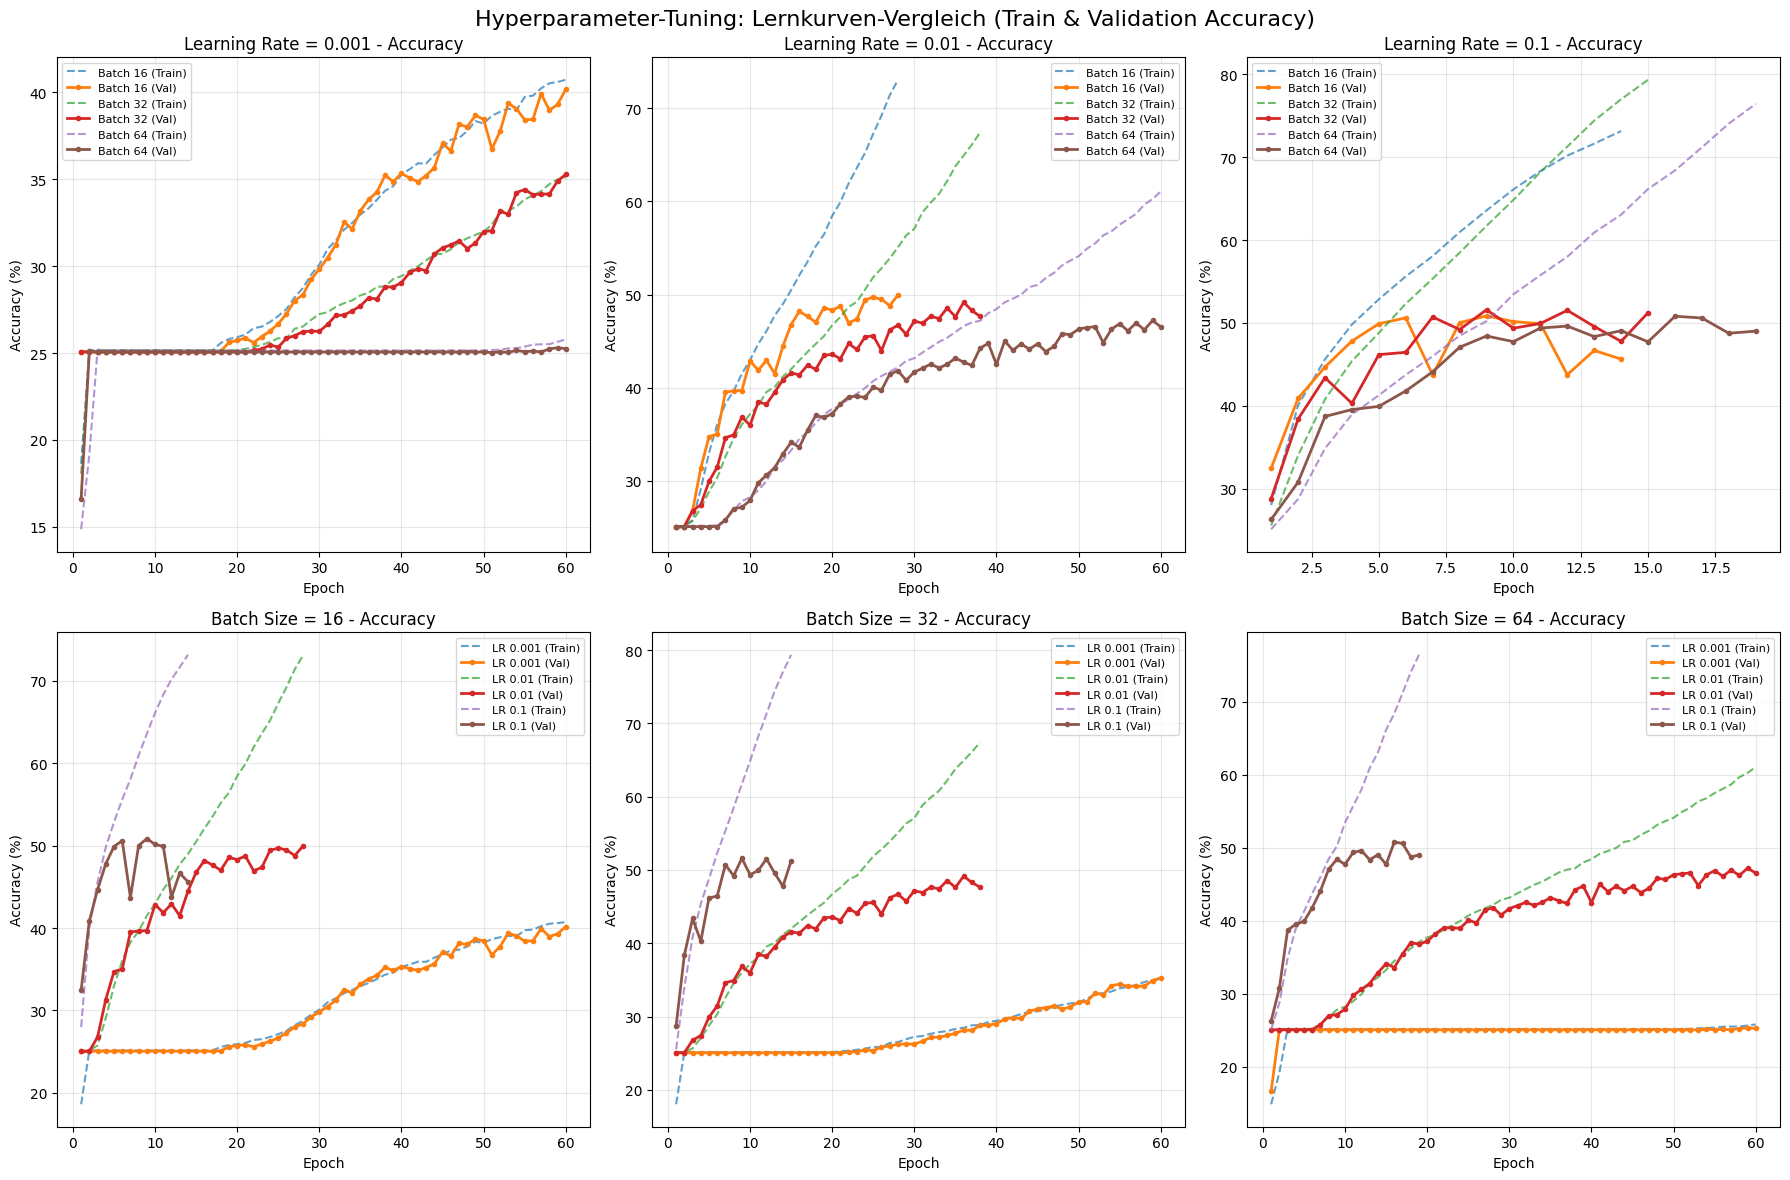

Performance-Übersicht gespeichert als 'plots/hyperparameter_performance_summary.png'


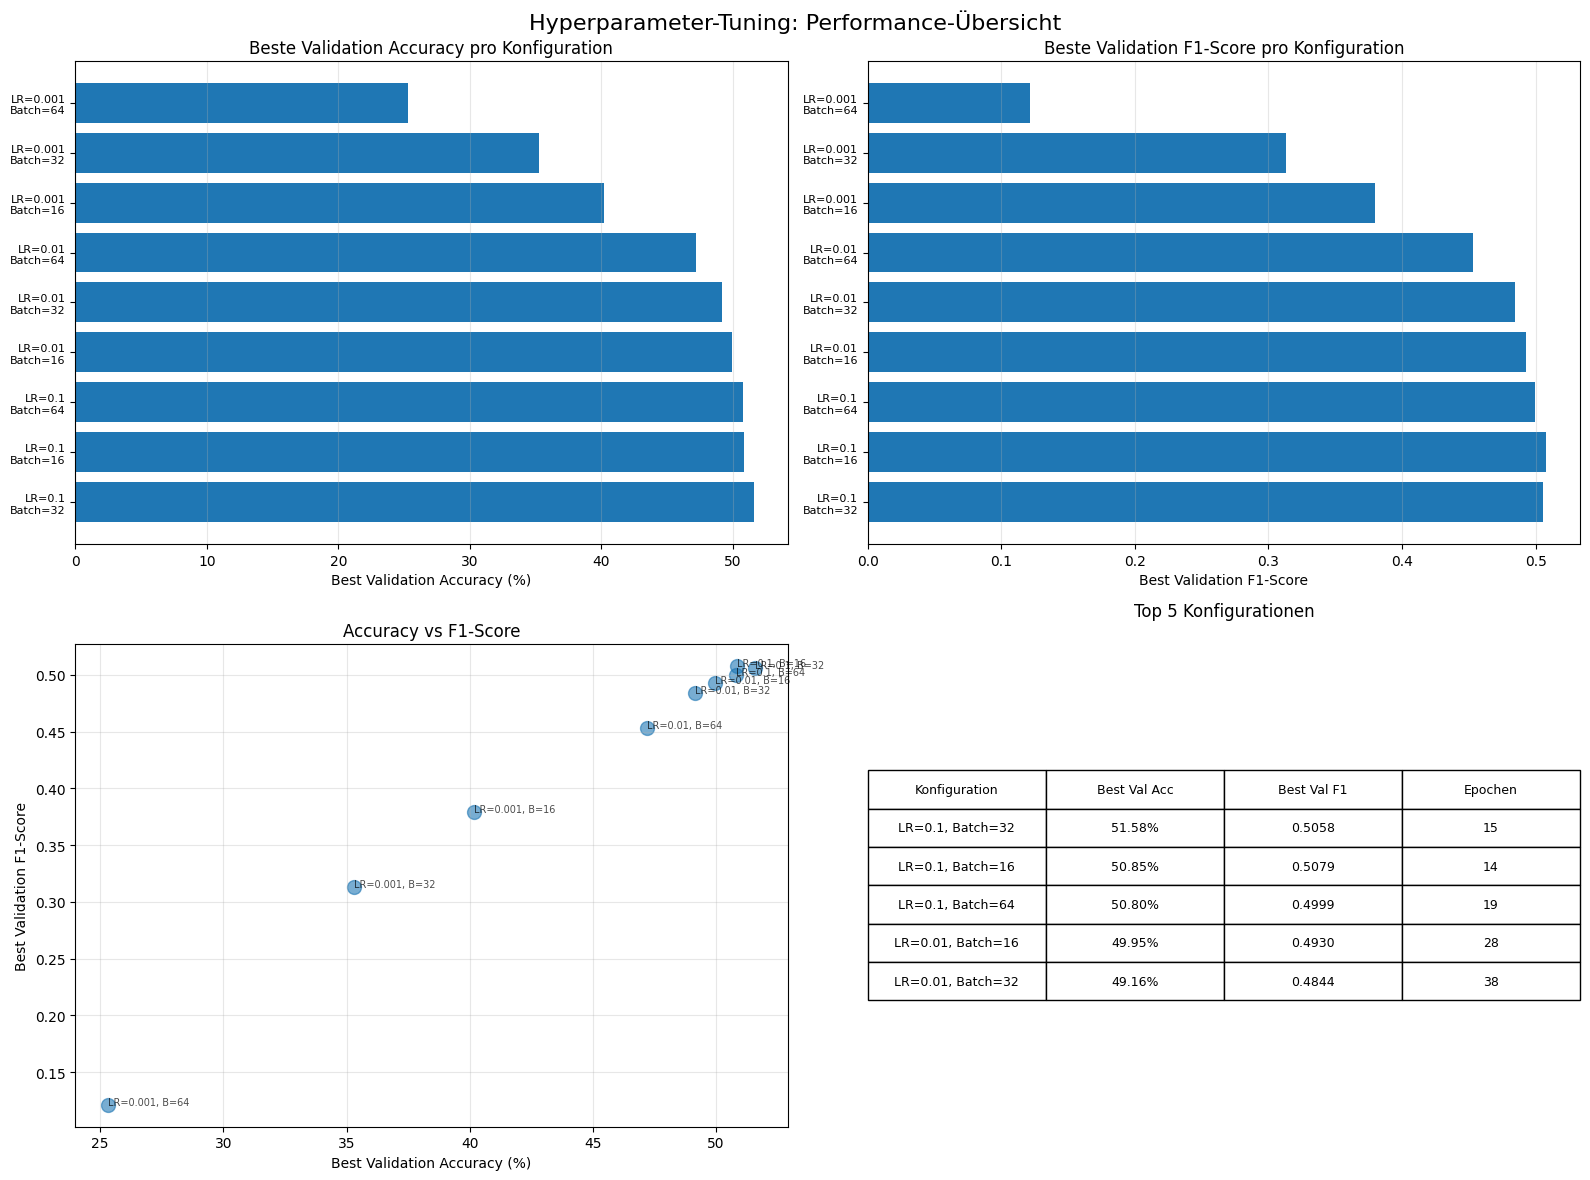

Hyperparameter-Plots gespeichert:
  - plots/hyperparameter_comparison.png
  - plots/hyperparameter_performance_summary.png


In [ ]:
# Lernkurven-Vergleich für verschiedene Konfigurationen (mit Trainingskurven)
# Sicherstellen, dass plots Verzeichnis existiert
os.makedirs('plots', exist_ok=True)

fig = plot_hyperparameter_comparison(
    results=results,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    save_path='plots/hyperparameter_comparison.png'
)

# Performance-Übersicht mit Accuracy, F1-Score, LR und Epochen
fig_perf = plot_hyperparameter_performance_summary(
    results=results,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    save_path='plots/hyperparameter_performance_summary.png'
)

print("Hyperparameter-Plots gespeichert:")
print("  - plots/hyperparameter_comparison.png")
print("  - plots/hyperparameter_performance_summary.png")


### Cross-Validation für statistische Fehlerschätzung

**Ziel:** Schätzung des statistischen Fehlers der Metriken durch Cross-Validation.

**Konfiguration:**
- **5-Fold Cross-Validation** auf dem Trainingsdatensatz
- **Beste Hyperparameter** aus dem Tuning verwenden
- **60 Epochen pro Fold** (konsistent mit Baseline-Training)
- **Early Stopping deaktiviert** für faire statistische Vergleichbarkeit
- **Statistische Auswertung:** Mittelwert ± Standardabweichung

**Hinweis zu Unsicherheiten:** Die Standardabweichung zeigt die Variabilität zwischen den Folds. 
Eine höhere Standardabweichung deutet auf größere Unsicherheit in den Ergebnissen hin, 
was durch unterschiedliche Datenverteilungen in den Folds oder Modell-Instabilität verursacht werden kann.


In [ ]:
# Cross-Validation für statistische Fehlerschätzung
print("=== Cross-Validation ===")

# Beste Hyperparameter aus dem Tuning verwenden
best_lr = best_config['Learning Rate']
best_batch = int(best_config['Batch Size'])

print(f"Verwende beste Konfiguration: LR={best_lr}, Batch={best_batch}")
print(f"WICHTIG: Alle Folds trainieren exakt 60 Epochen (Early Stopping deaktiviert)")
print("Dies stellt sicher, dass die statistische Vergleichbarkeit gewährleistet ist.")

# Cross-Validation durchführen
# Modell-Klasse wird als Parameter übergeben, Early Stopping ist deaktiviert
cv_results = cross_validation_training(
    train_dataset=full_train_dataset,
    model_class=BaselineCNN,  # Modell-Klasse als Parameter
    num_folds=5,
    num_epochs=60,  
    learning_rate=best_lr,
    batch_size=best_batch,
    img_size=img_size,
    num_classes=num_classes
)

print(f"\n=== Cross-Validation Ergebnisse (Mittelwert ± Standardabweichung) ===")
print(f"Training Accuracy: {cv_results['train_accuracies']['mean']:.4f} ± {cv_results['train_accuracies']['std']:.4f}")
print(f"Validation Accuracy: {cv_results['val_accuracies']['mean']:.4f} ± {cv_results['val_accuracies']['std']:.4f}")
print(f"Training Loss: {cv_results['train_losses']['mean']:.4f} ± {cv_results['train_losses']['std']:.4f}")
print(f"Validation Loss: {cv_results['val_losses']['mean']:.4f} ± {cv_results['val_losses']['std']:.4f}")

# F1-Scores ausgeben falls vorhanden
if 'train_f1s' in cv_results:
    print(f"Training F1-Score: {cv_results['train_f1s']['mean']:.4f} ± {cv_results['train_f1s']['std']:.4f}")
    print(f"Validation F1-Score: {cv_results['val_f1s']['mean']:.4f} ± {cv_results['val_f1s']['std']:.4f}")

# Sicherstellen, dass das results Verzeichnis existiert
os.makedirs('results', exist_ok=True)

with open('results/cross_validation_results.json', 'w') as f:
    json.dump({
        'best_hyperparameters': {
            'learning_rate': best_lr,
            'batch_size': best_batch
        },
        'cv_results': cv_results,
        'num_epochs': 60, 
        'note': 'Early Stopping wurde deaktiviert für konsistente Epochenanzahl'
    }, f, indent=2)

print("\nCross-Validation Ergebnisse gespeichert als 'results/cross_validation_results.json'")


=== Cross-Validation ===
Verwende beste Konfiguration: LR=0.1, Batch=32
WICHTIG: Alle Folds trainieren exakt 60 Epochen (Early Stopping deaktiviert)
Dies stellt sicher, dass die statistische Vergleichbarkeit gewährleistet ist.
Cross-Validation mit 5 Folds
Jeder Fold trainiert exakt 60 Epochen (Early Stopping deaktiviert für Konsistenz)

Fold 1/5
------------------------------
Training startet: 60 Epochen, LR=0.1, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8069 | Val Loss: 1.7599 | Train Acc: 25.02% | Val Acc: 27.01%
Epoch   5/60 | Train Loss: 1.3528 | Val Loss: 1.3521 | Train Acc: 47.66% | Val Acc: 48.38%
Epoch  10/60 | Train Loss: 0.9916 | Val Loss: 1.3311 | Train Acc: 62.66% | Val Acc: 52.49%
Epoch  15/60 | Train Loss: 0.6142 | Val Loss: 1.6960 | Train Acc: 77.63% | Val Acc: 51.90%
Epoch  20/60 | Train Loss: 0.3957 | Val Loss: 2.7129 | Train Acc: 85.95% | Val Acc: 50.66%
Epoch  25/60 | Train Loss: 0.3177 | Val Loss: 3.0033 | Tra

## Hyperparameter-Experimente: Kategorie 1 - Modellkomplexität

**Hinweis:** Die Hypothesen, Erwartungen und Analysen sind im `main.ipynb` dokumentiert. Hier werden nur die Experimente durchgeführt.

**WICHTIG - Experimentdesign:**
Jedes Experiment variiert **nur EINEN Parameter** und hält alle anderen Parameter auf der Baseline-Konfiguration:
- **Baseline-Konfiguration:** 3 Conv-Layer, Filter [16, 32, 64], FC-Layer 64 Neuronen
- **Hypothese 1:** Variiert nur die Anzahl Conv-Layer (2, 3, 4, 5)
- **Hypothese 2:** Variiert nur die Filter-Anzahl pro Layer ([8,16,32], [16,32,64], [32,64,128], [64,128,256])
- **Hypothese 3:** Variiert nur die FC-Layer Breite (32, 64, 128, 256, 512 Neuronen)

Diese isolierte Variation ermöglicht es, den Effekt jedes einzelnen Parameters zu verstehen.

In [4]:
# Baseline-Ergebnisse laden
baseline_results_file = 'results/baseline_results.json'

if os.path.exists(baseline_results_file):
    print("=== Lade gespeicherte Baseline-Ergebnisse ===")
    with open(baseline_results_file, 'r') as f:
        baseline_results = json.load(f)
    
    # Listen zurück in numpy arrays konvertieren (falls nötig)
    for key in ['train_losses', 'val_losses', 'train_accs', 'val_accs', 'train_f1s', 'val_f1s']:
        if key in baseline_results and isinstance(baseline_results[key], list):
            baseline_results[key] = np.array(baseline_results[key])
    
    print(f"Baseline-Ergebnisse geladen:")
    print(f"  - Parameter: {baseline_results['num_params']:,}")
    print(f"  - Beste Val Acc: {baseline_results['best_val_acc']:.2f}% (Epoche {baseline_results['best_epoch']})")
    print(f"  - Finale Val Acc: {baseline_results['final_val_acc']:.2f}%")
    print(f"  - Experiment: {baseline_results['experiment_name']}")
else:
    print("Warnung: Baseline-Ergebnisse nicht gefunden!")

=== Lade gespeicherte Baseline-Ergebnisse ===
Baseline-Ergebnisse geladen:
  - Parameter: 171,271
  - Beste Val Acc: 48.87% (Epoche 42)
  - Finale Val Acc: 46.46%
  - Experiment: baseline_model


### Hypothese 1: Modelltiefe (Anzahl Conv-Layer)

**Variiert:** Nur die Anzahl Conv-Layer (2, 3, 4, 5)  
**Baseline-Parameter:** Filter [16, 32, 64], FC-Layer 64 Neuronen

In [5]:
# Hypothese 1 Ergebnisse initialisieren
hypothesis_1_file = 'results/hypothesis_1_depth.json'
hypothesis_1_results = {}

# Experiment 1.1: Baseline (3 Layer)
print("\n" + "-"*60)
print("Experiment 1.1: Baseline (3 Conv-Layer)")
print("Filter: [16, 32, 64] (Baseline)")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

# Baseline-Ergebnisse wiederverwenden
# Experiment-Name anpassen für bessere Nachverfolgbarkeit
baseline_results_hyp1 = baseline_results.copy()
baseline_results_hyp1['experiment_name'] = 'hyp1_baseline_3layers'
hypothesis_1_results['3_layers'] = baseline_results_hyp1

print(f"Baseline-Ergebnisse:")
print(f"  - Beste Val Acc: {baseline_results_hyp1['best_val_acc']:.2f}% (Epoche {baseline_results_hyp1['best_epoch']})")
print(f"  - Finale Val Acc: {baseline_results_hyp1['final_val_acc']:.2f}%")

# Automatisch speichern
save_hypothesis_results(hypothesis_1_results, hypothesis_1_file)


------------------------------------------------------------
Experiment 1.1: Baseline (3 Conv-Layer)
Filter: [16, 32, 64] (Baseline)
FC-Layer: 64 Neuronen (Baseline)
------------------------------------------------------------
Baseline-Ergebnisse:
  - Beste Val Acc: 48.87% (Epoche 42)
  - Finale Val Acc: 46.46%
Ergebnisse gespeichert: results/hypothesis_1_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_1_depth.json


In [6]:
# Experiment 1.2: 2 Layer
print("\n" + "-"*60)
print("Experiment 1.2: 2 Conv-Layer")
print("Filter: [16, 32]")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

result_2 = run_hyperparameter_experiment(
    experiment_name="hyp1_2layers",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 2,  
        'filters_per_layer': [16, 32]  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_1_results['2_layers'] = result_2

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_1_results, hypothesis_1_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()


------------------------------------------------------------
Experiment 1.2: 2 Conv-Layer
Filter: [16, 32]
FC-Layer: 64 Neuronen (Baseline)
------------------------------------------------------------

EXPERIMENT: hyp1_2layers
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 2, 'filters_per_layer': [16, 32]}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 300,231 total, 300,231 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
Early Stopping: patience=15, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8140 | Val Loss: 1.7857 | Train Acc: 24.89% | Val Acc: 24.96% | Patience: 0/15
Epoch   5/60 | Train Loss: 1.6664 | Val Loss: 1.6477 | Train Acc: 34.80% | Val Acc: 35.07% | Patience: 0/15
Epoch  10/60 | Train Loss: 1.5593 | Val Loss: 1.5675 | Train Acc: 39.86% | Val Acc: 38.80% | Patience: 0/15
Epoch  15/60 | Train Loss: 1.4444 | Val Loss: 1.4689 | Train Acc: 44.71% | Val Acc: 43.59% | Patience: 0/15
Epoch  20/60 | Train Loss: 1.3233 | Val Loss: 1.4120 | Train Acc: 50.09% | Val Acc: 45.38% | Patience: 0/15
Epoch  25/60 | Train Loss: 1.1996 | Val Loss: 1.4050 | Train Acc: 55.33% | Val Acc: 46.12% | Patience: 1/15
Epoch  30/60 | Train Loss: 1.0619 | Val Loss: 1.4162 | Train Acc: 60.91% | Val Acc: 47.35% | Patience: 6/15
Epoch  35/60 | Train Loss: 0.8991 | Val Loss: 1.5245 | Train Acc: 67.44% | Val Acc: 46.90%

best_val_loss,█▇▇▆▆▅▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_acc,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_f1,▁▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,██▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
val_acc,▁▂▃▄▄▅▄▅▅▅▅▆▆▆▇▇▆▆▇▇█▇▇█▇███▇████▇█▇██▇
val_f1,▁▂▃▅▅▅▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████████████████
val_loss,█▇▇▆▆▅▅▅▅▄▄▃▃▃▃▃▂▃▂▂▂▂▁▁▂▁▂▂▂▂▂▂▂▅▄▄▄▅▅
best_val_loss,1.37499
epoch,39



ERGEBNISSE: hyp1_2layers
Beste Validation Accuracy: 48.26% (Epoche 33)
Finale Validation Accuracy: 45.75%
Finale Validation F1-Score: 0.4591
Overfitting-Gap (Acc): 27.31%
Test Accuracy: 0.47%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_1_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_1_depth.json


33

In [7]:
# Experiment 1.3: 4 Layer
print("\n" + "-"*60)
print("Experiment 1.3: 4 Conv-Layer")
print("Filter: [16, 32, 64, 128]")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

result_4 = run_hyperparameter_experiment(
    experiment_name="hyp1_4layers",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 4, 
        'filters_per_layer': [16, 32, 64, 128] 
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_1_results['4_layers'] = result_4

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_1_results, hypothesis_1_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()


------------------------------------------------------------
Experiment 1.3: 4 Conv-Layer
Filter: [16, 32, 64, 128]
FC-Layer: 64 Neuronen (Baseline)
------------------------------------------------------------

EXPERIMENT: hyp1_4layers
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 4, 'filters_per_layer': [16, 32, 64, 128]}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,399 total, 171,399 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
Early Stopping: patience=15, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8587 | Val Loss: 1.8079 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/15
Epoch   5/60 | Train Loss: 1.8079 | Val Loss: 1.8001 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/15
Epoch  10/60 | Train Loss: 1.7542 | Val Loss: 1.7452 | Train Acc: 27.82% | Val Acc: 28.21% | Patience: 0/15
Epoch  15/60 | Train Loss: 1.6292 | Val Loss: 1.6245 | Train Acc: 36.13% | Val Acc: 35.44% | Patience: 0/15
Epoch  20/60 | Train Loss: 1.5006 | Val Loss: 1.4962 | Train Acc: 42.01% | Val Acc: 41.87% | Patience: 0/15
Epoch  25/60 | Train Loss: 1.3924 | Val Loss: 1.4452 | Train Acc: 46.30% | Val Acc: 43.50% | Patience: 1/15
Epoch  30/60 | Train Loss: 1.2838 | Val Loss: 1.3743 | Train Acc: 51.13% | Val Acc: 46.92% | Patience: 0/15
Epoch  35/60 | Train Loss: 1.1636 | Val Loss: 1.3977 | Train Acc: 56.06% | Val Acc: 47.86%

best_val_loss,█████▇▇▇▇▆▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▂▂▃▃▄▅▆▇▇█
train_acc,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
train_f1,▁▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_loss,███████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▁▁
val_acc,▁▁▁▁▁▁▁▂▂▂▄▄▅▅▅▆▆▆▆▆▇▇▇▆▆▇▇▇▇████▇▇▇█▇██
val_f1,▁▁▁▁▁▁▂▂▃▄▄▄▄▅▅▅▆▆▆▇▇▇▆▇▇▇▇▇▇██▇█▇██████
val_loss,▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▂▁▁▁▂▂▃▄▃▄▅▄▅█
best_val_loss,1.3527
epoch,55



ERGEBNISSE: hyp1_4layers
Beste Validation Accuracy: 50.70% (Epoche 51)
Finale Validation Accuracy: 49.56%
Finale Validation F1-Score: 0.5008
Overfitting-Gap (Acc): 30.50%
Test Accuracy: 0.49%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_1_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_1_depth.json


33

In [8]:
# Experiment 1.4: 6 Layer 
print("\n" + "-"*60)
print("Experiment 1.4: 6 Conv-Layer")
print("Filter: [16, 32, 64, 128, 256, 512]")
print("FC-Layer: 64 Neuronen (Baseline)")
print("Pooling: Nach Layer 1, 2, 3 (wie Baseline), dann kein Pooling mehr")
print("-"*60)

result_6 = run_hyperparameter_experiment(
    experiment_name="hyp1_6layers",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 6, 
        'filters_per_layer': [16, 32, 64, 128, 256, 512],
        'pool_after_layers': [0, 1, 2]  # Pooling nur nach den ersten 3 Layern
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32,  
    device=device,
    use_wandb=True
)
hypothesis_1_results['6_layers'] = result_6

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_1_results, hypothesis_1_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()


------------------------------------------------------------
Experiment 1.4: 6 Conv-Layer
Filter: [16, 32, 64, 128, 256, 512]
FC-Layer: 64 Neuronen (Baseline)
Pooling: Nach Layer 1, 2, 3 (wie Baseline), dann kein Pooling mehr
------------------------------------------------------------

EXPERIMENT: hyp1_6layers
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 6, 'filters_per_layer': [16, 32, 64, 128, 256, 512], 'pool_after_layers': [0, 1, 2]}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 2,752,647 total, 2,752,647 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
Early Stopping: patience=15, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8500 | Val Loss: 1.8061 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/15
Epoch   5/60 | Train Loss: 1.8114 | Val Loss: 1.8049 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/15
Epoch  10/60 | Train Loss: 1.8025 | Val Loss: 1.7919 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/15
Epoch  15/60 | Train Loss: 1.7807 | Val Loss: 1.7762 | Train Acc: 25.49% | Val Acc: 25.10% | Patience: 0/15
Epoch  20/60 | Train Loss: 1.7516 | Val Loss: 1.7359 | Train Acc: 27.98% | Val Acc: 28.11% | Patience: 0/15
Epoch  25/60 | Train Loss: 1.6258 | Val Loss: 1.6202 | Train Acc: 36.63% | Val Acc: 35.72% | Patience: 0/15
Epoch  30/60 | Train Loss: 1.5037 | Val Loss: 1.5103 | Train Acc: 41.93% | Val Acc: 40.75% | Patience: 0/15
Epoch  35/60 | Train Loss: 1.3968 | Val Loss: 1.4373 | Train Acc: 46.48% | Val Acc: 43.56%

best_val_loss,████████████▇▇▇▇▆▆▅▅▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
patience_counter,▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▅▆▇▇█
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▇▇▇█
train_f1,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇█
train_loss,███████████████▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▄▄▄▃▃▂▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇██▇████▇▇
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▄▄▅▅▆▆▆▇▇▇▇▇█▇█████████
val_loss,▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▂▂▃▅█
best_val_loss,1.38117
epoch,55



ERGEBNISSE: hyp1_6layers
Beste Validation Accuracy: 49.13% (Epoche 48)
Finale Validation Accuracy: 47.02%
Finale Validation F1-Score: 0.4740
Overfitting-Gap (Acc): 40.57%
Test Accuracy: 0.48%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_1_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_1_depth.json


33

In [10]:
def plot_experiment_comparison(results_dict, metric='val_acc', title='Experiment Comparison'):
    """
    Plottet Vergleich mehrerer Experimente.
    
    Args:
        results_dict: Dictionary mit Experiment-Ergebnissen
                      Key: Experiment-Name, Value: results dict von run_hyperparameter_experiment
        metric: Metrik zum Plotten ('val_acc', 'train_acc', 'val_loss', etc.)
        title: Titel des Plots
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Linker Plot: Training Curves
    ax1 = axes[0]
    for exp_name, results in results_dict.items():
        if metric in results:
            metric_key = metric
        elif f"{metric}s" in results:
            metric_key = f"{metric}s"
        else:
            # Falls Metrik nicht vorhanden ist, Experiment überspringen
            print(f"Warnung: Metrik '{metric}' (oder '{metric}s') nicht in Ergebnissen für Experiment '{exp_name}' gefunden.")
            continue

        epochs = range(1, len(results[metric_key]) + 1)
        ax1.plot(epochs, results[metric_key], label=exp_name, linewidth=2)
    
    ax1.set_xlabel('Epoche', fontsize=12)
    ax1.set_ylabel(metric.replace('_', ' ').title(), fontsize=12)
    ax1.set_title(f'{title} - Training Curves', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Rechter Plot: Finale Metriken
    ax2 = axes[1]
    exp_names = list(results_dict.keys())
    final_metrics = [results_dict[name][f'final_{metric}'] for name in exp_names]
    
    bars = ax2.bar(exp_names, final_metrics, alpha=0.7)
    ax2.set_ylabel(f'Finale {metric.replace("_", " ").title()}', fontsize=12)
    ax2.set_title(f'{title} - Finale Metriken', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Werte auf Bars anzeigen
    for bar, val in zip(bars, final_metrics):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    return fig


ANALYSE HYPOTHESE 1: MODELLTIEFE

Zusammenfassung der Ergebnisse:
Konfiguration Parameter Beste Val Acc (%) Finale Val Acc (%) Finale Val F1 Overfitting-Gap (%)  Beste Epoche
     3_layers   171,271             48.87              46.46        0.4665               31.64            42
     2_layers   300,231             48.26              45.75        0.4591               27.31            33
     4_layers   171,399             50.70              49.56        0.5008               30.50            51
     6_layers 2,752,647             49.13              47.02        0.4740               40.57            48


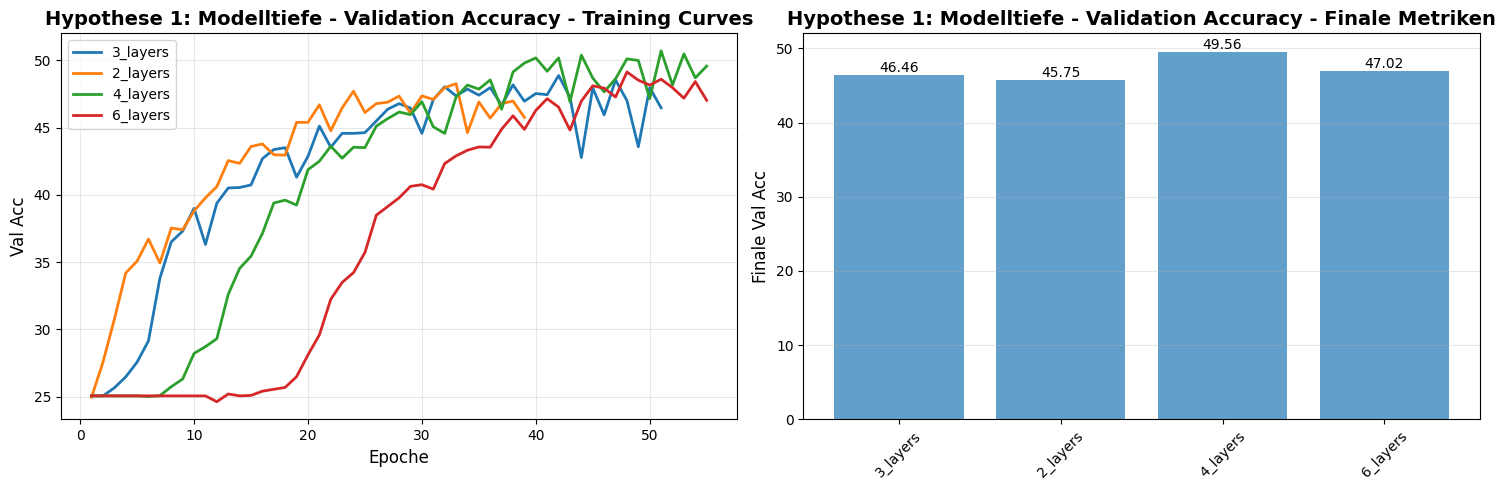

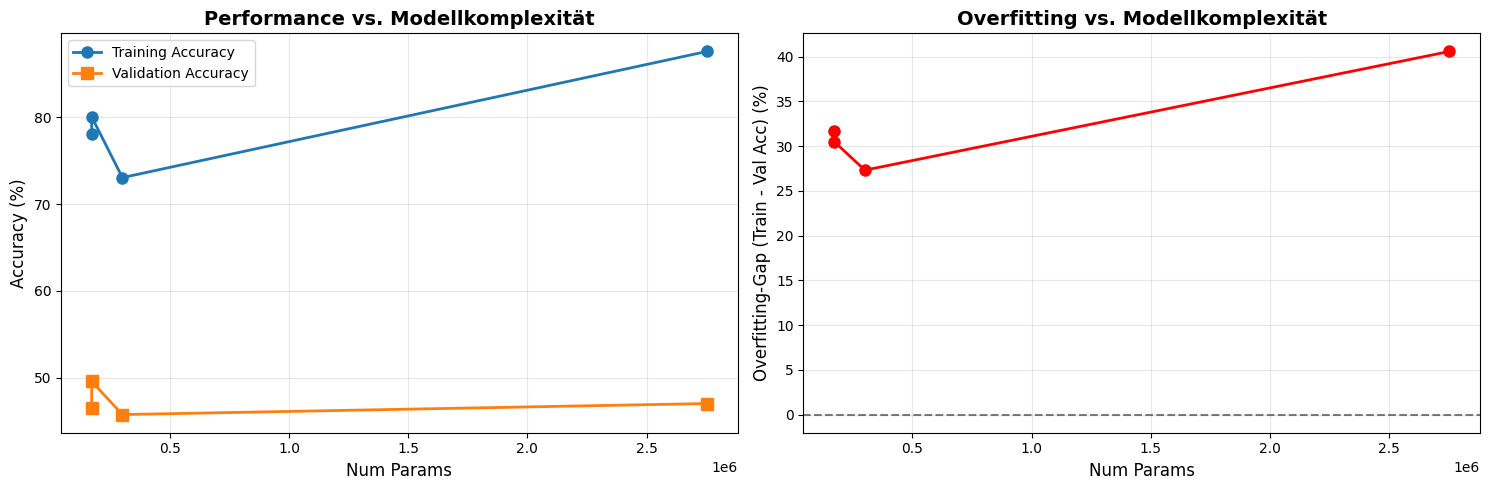

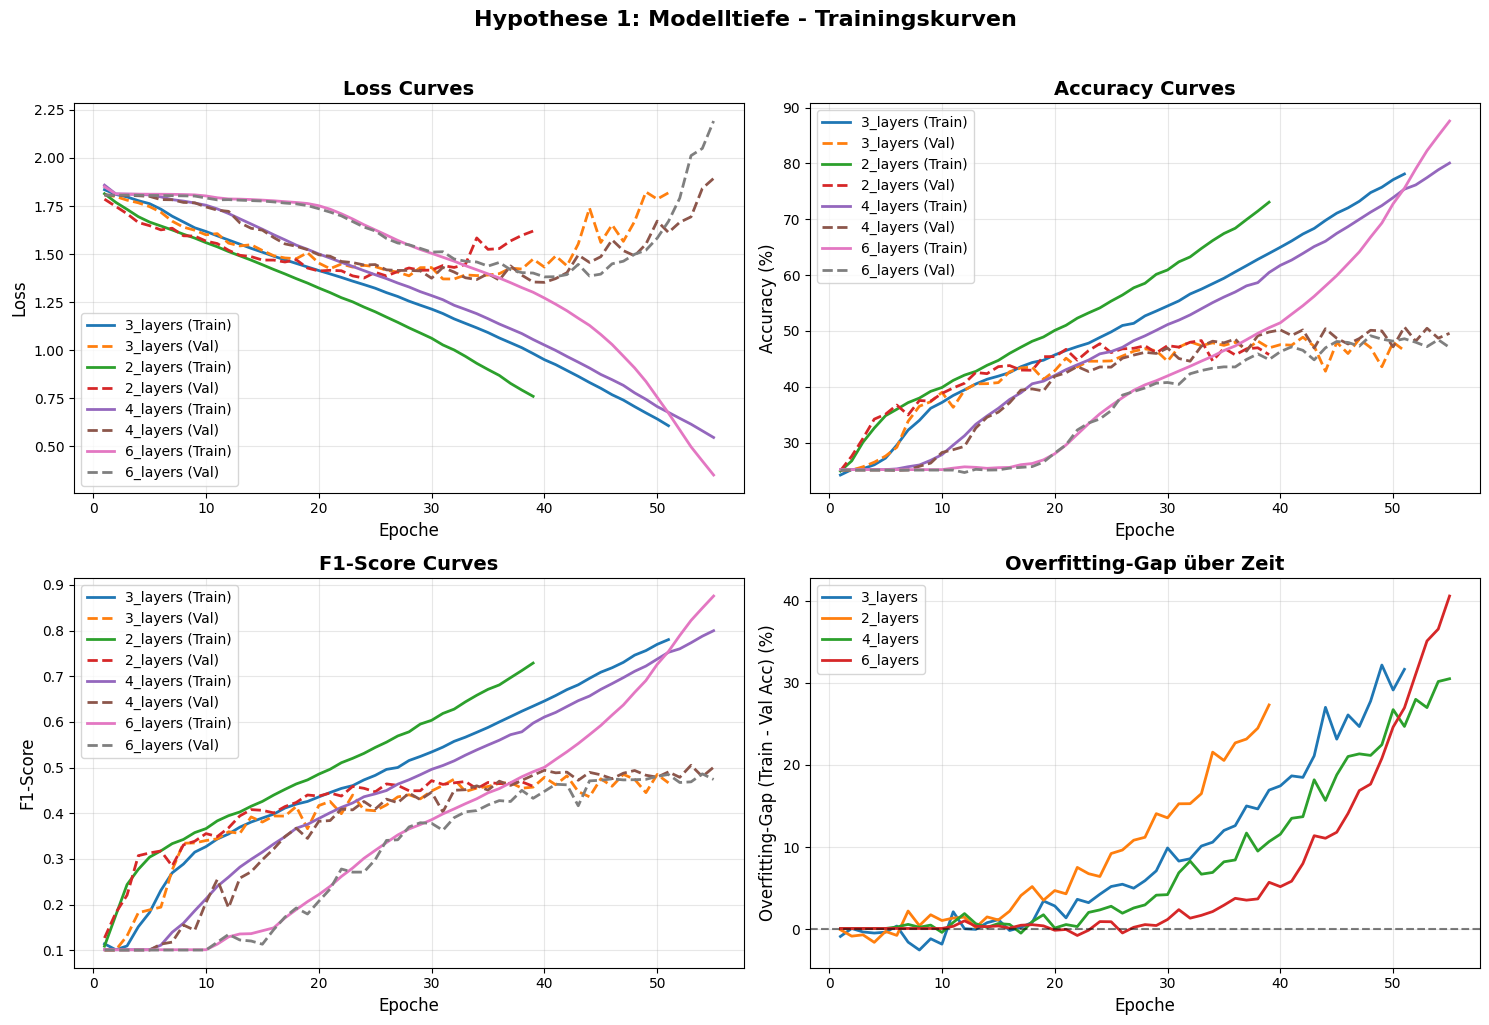

Ergebnisse gespeichert: results/hypothesis_1_depth.json

Ergebnisse gespeichert: results/hypothesis_1_depth.json


In [ ]:
# Analyse und Visualisierung Hypothese 1
print("\n" + "="*80)
print("ANALYSE HYPOTHESE 1: MODELLTIEFE")
print("="*80)

# Zusammenfassungstabelle
summary_data = []
for name, result in hypothesis_1_results.items():
    summary_data.append({
        'Konfiguration': name,
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Finale Val F1': f"{result['final_val_f1']:.4f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}",
        'Beste Epoche': result['best_epoch']
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung der Ergebnisse:")
print(df_summary.to_string(index=False))

# Visualisierung
os.makedirs('plots/experiments', exist_ok=True)

fig = plot_experiment_comparison(hypothesis_1_results, metric='val_acc', 
                                 title='Hypothese 1: Modelltiefe - Validation Accuracy')
plt.savefig('plots/experiments/hyp1_depth_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_model_complexity_analysis(hypothesis_1_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp1_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_training_curves_comparison(hypothesis_1_results, 
                                     title='Hypothese 1: Modelltiefe - Trainingskurven')
plt.savefig('plots/experiments/hyp1_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Ergebnisse speichern
save_experiment_results(hypothesis_1_results, 'results/hypothesis_1_depth.json')
print("\nErgebnisse gespeichert: results/hypothesis_1_depth.json")

### Hypothese 2: Modellbreite (Filter-Anzahl)

**Variiert:** Nur die Filter-Anzahl pro Layer ([8, 16, 32], [16, 32, 64], [32, 64, 128], [64, 128, 256])  
**Konstant:** 3 Conv-Layer (Baseline), FC-Layer 64 Neuronen (Baseline)

In [13]:
# Hypothese 2 Ergebnisse initialisieren
hypothesis_2_file = 'results/hypothesis_2_depth.json'
hypothesis_2_results = {}

# Experiment 2.1: Baseline (3 Layer)
print("\n" + "-"*60)
print("Experiment 2.1: Baseline (3 Conv-Layer)")
print("Filter: [16, 32, 64] (Baseline)")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

# Baseline-Ergebnisse wiederverwenden
# Experiment-Name anpassen für bessere Nachverfolgbarkeit
baseline_results_hyp2 = baseline_results.copy()
baseline_results_hyp2['experiment_name'] = 'hyp2_baseline_3layers'
hypothesis_2_results['3_layers'] = baseline_results_hyp2

print(f"Baseline-Ergebnisse:")
print(f"  - Beste Val Acc: {baseline_results_hyp2['best_val_acc']:.2f}% (Epoche {baseline_results_hyp2['best_epoch']})")
print(f"  - Finale Val Acc: {baseline_results_hyp2['final_val_acc']:.2f}%")

# Automatisch speichern
save_hypothesis_results(hypothesis_2_results, hypothesis_2_file)


------------------------------------------------------------
Experiment 2.1: Baseline (3 Conv-Layer)
Filter: [16, 32, 64] (Baseline)
FC-Layer: 64 Neuronen (Baseline)
------------------------------------------------------------
Baseline-Ergebnisse:
  - Beste Val Acc: 48.87% (Epoche 42)
  - Finale Val Acc: 46.46%
Ergebnisse gespeichert: results/hypothesis_2_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_2_depth.json


In [14]:
# Experiment 2.2: [8, 16, 32] Filter 
print("\n" + "-"*60)
print("Experiment 2.2: [8, 16, 32] Filter")
print("-"*60)

result_narrow = run_hyperparameter_experiment(
    experiment_name="hyp2_narrow_8_16_32",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3, 
        'filters_per_layer': [8, 16, 32] 
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32,  
    device=device,
    use_wandb=True
)
hypothesis_2_results['8_16_32'] = result_narrow

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_2_results, hypothesis_2_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()


------------------------------------------------------------
Experiment 2.2: [8, 16, 32] Filter
------------------------------------------------------------

EXPERIMENT: hyp2_narrow_8_16_32
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [8, 16, 32]}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 80,135 total, 80,135 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
Early Stopping: patience=15, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8370 | Val Loss: 1.8069 | Train Acc: 24.97% | Val Acc: 25.06% | Patience: 0/15
Epoch   5/60 | Train Loss: 1.7934 | Val Loss: 1.7833 | Train Acc: 25.22% | Val Acc: 24.99% | Patience: 0/15
Epoch  10/60 | Train Loss: 1.6796 | Val Loss: 1.6918 | Train Acc: 33.42% | Val Acc: 31.21% | Patience: 1/15
Epoch  15/60 | Train Loss: 1.5650 | Val Loss: 1.5626 | Train Acc: 39.85% | Val Acc: 39.59% | Patience: 0/15
Epoch  20/60 | Train Loss: 1.4626 | Val Loss: 1.4886 | Train Acc: 43.83% | Val Acc: 41.68% | Patience: 1/15
Epoch  25/60 | Train Loss: 1.3686 | Val Loss: 1.4229 | Train Acc: 47.86% | Val Acc: 44.88% | Patience: 0/15
Epoch  30/60 | Train Loss: 1.2704 | Val Loss: 1.3736 | Train Acc: 51.94% | Val Acc: 47.11% | Patience: 0/15
Epoch  35/60 | Train Loss: 1.1676 | Val Loss: 1.3700 | Train Acc: 56.08% | Val Acc: 48.24%

best_val_loss,█████▆▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▂▃▃▄▅▆▇▇█
train_acc,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_f1,▁▁▁▁▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,█████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
val_acc,▁▁▁▁▁▃▃▃▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇██▇██▇███▇
val_f1,▁▁▁▁▁▃▄▄▄▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
val_loss,███▇▇▆▆▅▅▄▄▃▃▃▃▂▂▃▂▂▂▁▁▁▁▁▁▁▂▁▂▁▂▂▂▃▂▂▃▄
best_val_loss,1.35929
epoch,52



ERGEBNISSE: hyp2_narrow_8_16_32
Beste Validation Accuracy: 50.66% (Epoche 49)
Finale Validation Accuracy: 48.55%
Finale Validation F1-Score: 0.4860
Overfitting-Gap (Acc): 23.24%
Test Accuracy: 0.48%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_2_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_2_depth.json


4940

In [15]:
# Experiment 2.3: [32, 64, 128] Filter 
print("\n" + "-"*60)
print("Experiment 2.3: [32, 64, 128] Filter")
print("-"*60)

result_wide1 = run_hyperparameter_experiment(
    experiment_name="hyp2_wide_32_64_128",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,  
        'filters_per_layer': [32, 64, 128]  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_2_results['32_64_128'] = result_wide1

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_2_results, hypothesis_2_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()


------------------------------------------------------------
Experiment 2.3: [32, 64, 128] Filter
------------------------------------------------------------

EXPERIMENT: hyp2_wide_32_64_128
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [32, 64, 128]}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 388,103 total, 388,103 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
Early Stopping: patience=15, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8324 | Val Loss: 1.8124 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/15
Epoch   5/60 | Train Loss: 1.7412 | Val Loss: 1.7307 | Train Acc: 28.64% | Val Acc: 29.48% | Patience: 0/15
Epoch  10/60 | Train Loss: 1.5930 | Val Loss: 1.5893 | Train Acc: 38.40% | Val Acc: 38.02% | Patience: 0/15
Epoch  15/60 | Train Loss: 1.4697 | Val Loss: 1.4857 | Train Acc: 43.69% | Val Acc: 41.97% | Patience: 0/15
Epoch  20/60 | Train Loss: 1.3599 | Val Loss: 1.4200 | Train Acc: 48.34% | Val Acc: 45.12% | Patience: 1/15
Epoch  25/60 | Train Loss: 1.2369 | Val Loss: 1.3524 | Train Acc: 53.41% | Val Acc: 48.68% | Patience: 0/15
Epoch  30/60 | Train Loss: 1.0982 | Val Loss: 1.3380 | Train Acc: 59.09% | Val Acc: 49.49% | Patience: 0/15
Epoch  35/60 | Train Loss: 0.9352 | Val Loss: 1.3834 | Train Acc: 65.94% | Val Acc: 50.30%

best_val_loss,███▇▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂▃▁▁▂▂▃▃▄▅▅▆▆▇▇█
train_acc,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
train_f1,▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█████▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
val_acc,▁▁▁▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█▇▇█▇██▇██████
val_f1,▁▁▂▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇█▇▇████▇██████
val_loss,██▇▇▇▆▅▆▅▄▄▄▃▃▃▃▂▂▄▂▂▁▁▂▂▂▁▂▂▁▃▂▃▃▂▃▄▅▅█
best_val_loss,1.338
epoch,45



ERGEBNISSE: hyp2_wide_32_64_128
Beste Validation Accuracy: 51.22% (Epoche 40)
Finale Validation Accuracy: 49.90%
Finale Validation F1-Score: 0.4819
Overfitting-Gap (Acc): 31.07%
Test Accuracy: 0.51%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_2_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_2_depth.json


33

In [16]:
# Experiment 2.4: [64, 128, 256] Filter 
print("\n" + "-"*60)
print("Experiment 2.4: [64, 128, 256] Filter")
print("-"*60)

result_wide2 = run_hyperparameter_experiment(
    experiment_name="hyp2_very_wide_64_128_256",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3, 
        'filters_per_layer': [64, 128, 256]  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_2_results['64_128_256'] = result_wide2

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_2_results, hypothesis_2_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()


------------------------------------------------------------
Experiment 2.4: [64, 128, 256] Filter
------------------------------------------------------------

EXPERIMENT: hyp2_very_wide_64_128_256
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [64, 128, 256]}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 960,007 total, 960,007 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
Early Stopping: patience=15, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8305 | Val Loss: 1.8094 | Train Acc: 24.77% | Val Acc: 25.06% | Patience: 0/15
Epoch   5/60 | Train Loss: 1.7343 | Val Loss: 1.7085 | Train Acc: 29.70% | Val Acc: 30.63% | Patience: 0/15
Epoch  10/60 | Train Loss: 1.5712 | Val Loss: 1.5601 | Train Acc: 39.69% | Val Acc: 39.69% | Patience: 0/15
Epoch  15/60 | Train Loss: 1.4345 | Val Loss: 1.4476 | Train Acc: 45.28% | Val Acc: 43.85% | Patience: 0/15
Epoch  20/60 | Train Loss: 1.3045 | Val Loss: 1.3780 | Train Acc: 50.37% | Val Acc: 46.76% | Patience: 0/15
Epoch  25/60 | Train Loss: 1.1621 | Val Loss: 1.3135 | Train Acc: 56.15% | Val Acc: 50.00% | Patience: 0/15
Epoch  30/60 | Train Loss: 0.9988 | Val Loss: 1.3094 | Train Acc: 63.04% | Val Acc: 51.60% | Patience: 4/15
Epoch  35/60 | Train Loss: 0.7948 | Val Loss: 1.3773 | Train Acc: 70.91% | Val Acc: 52.46%

best_val_loss,███▇▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_acc,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
train_f1,▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss,████▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁
val_acc,▁▁▁▂▂▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▆▇▇▇█▇████▇▇██▇▇██
val_f1,▁▁▁▂▃▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█▇█▇▇██▇▇▇█▇█▇▇█
val_loss,███▇▇▆▆▅▅▅▄▄▄▃▃▃▃▂▃▂▂▂▂▁▁▁▁▂▁▁▁▂▃▃▂▄▃▅▅▇
best_val_loss,1.29753
epoch,41



ERGEBNISSE: hyp2_very_wide_64_128_256
Beste Validation Accuracy: 52.46% (Epoche 35)
Finale Validation Accuracy: 50.73%
Finale Validation F1-Score: 0.4983
Overfitting-Gap (Acc): 31.16%
Test Accuracy: 0.52%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_2_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_2_depth.json


33


ANALYSE HYPOTHESE 2: MODELLBREITE

Zusammenfassung der Ergebnisse:
Konfiguration Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
     3_layers   171,271             48.87              46.46               31.64
      8_16_32    80,135             50.66              48.55               23.24
    32_64_128   388,103             51.22              49.90               31.07
   64_128_256   960,007             52.46              50.73               31.16


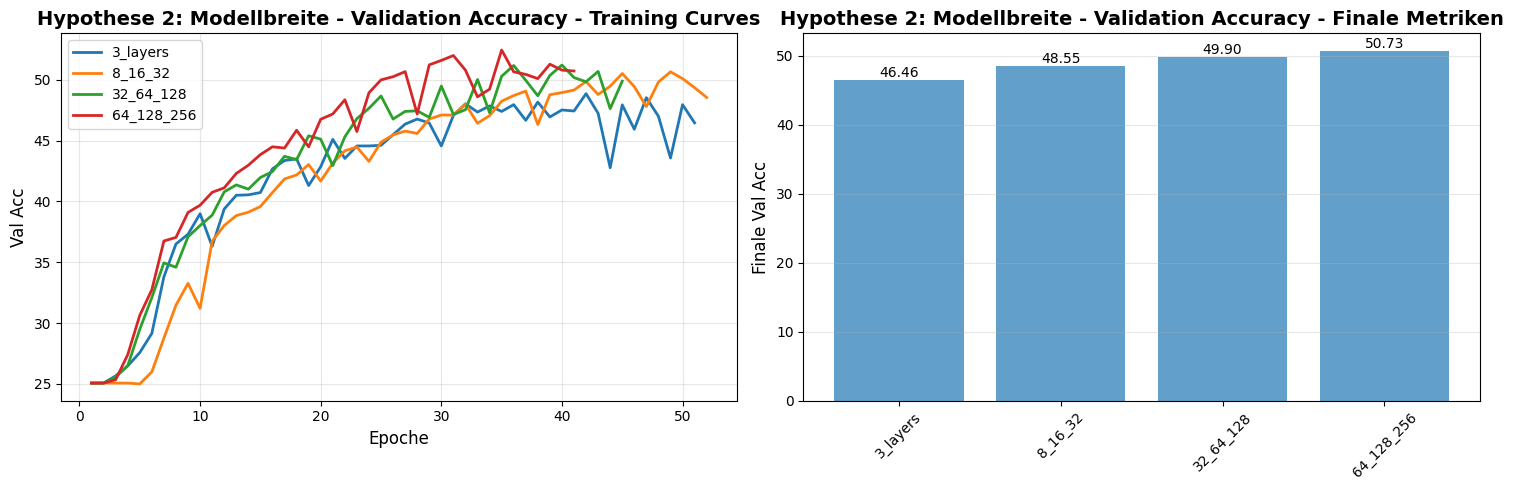

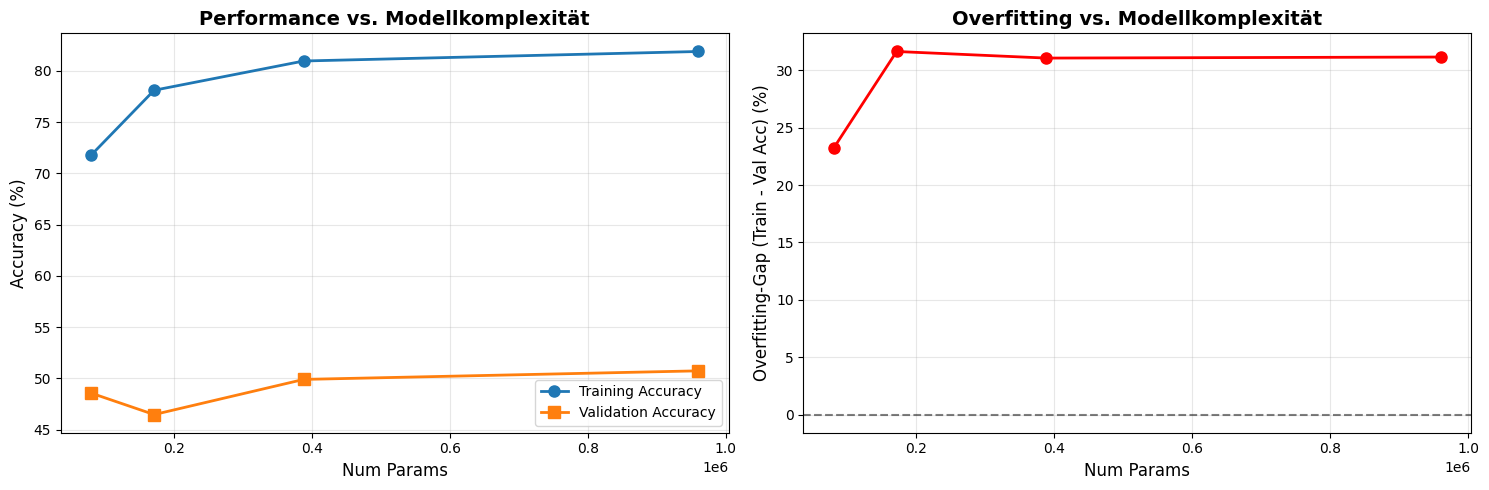

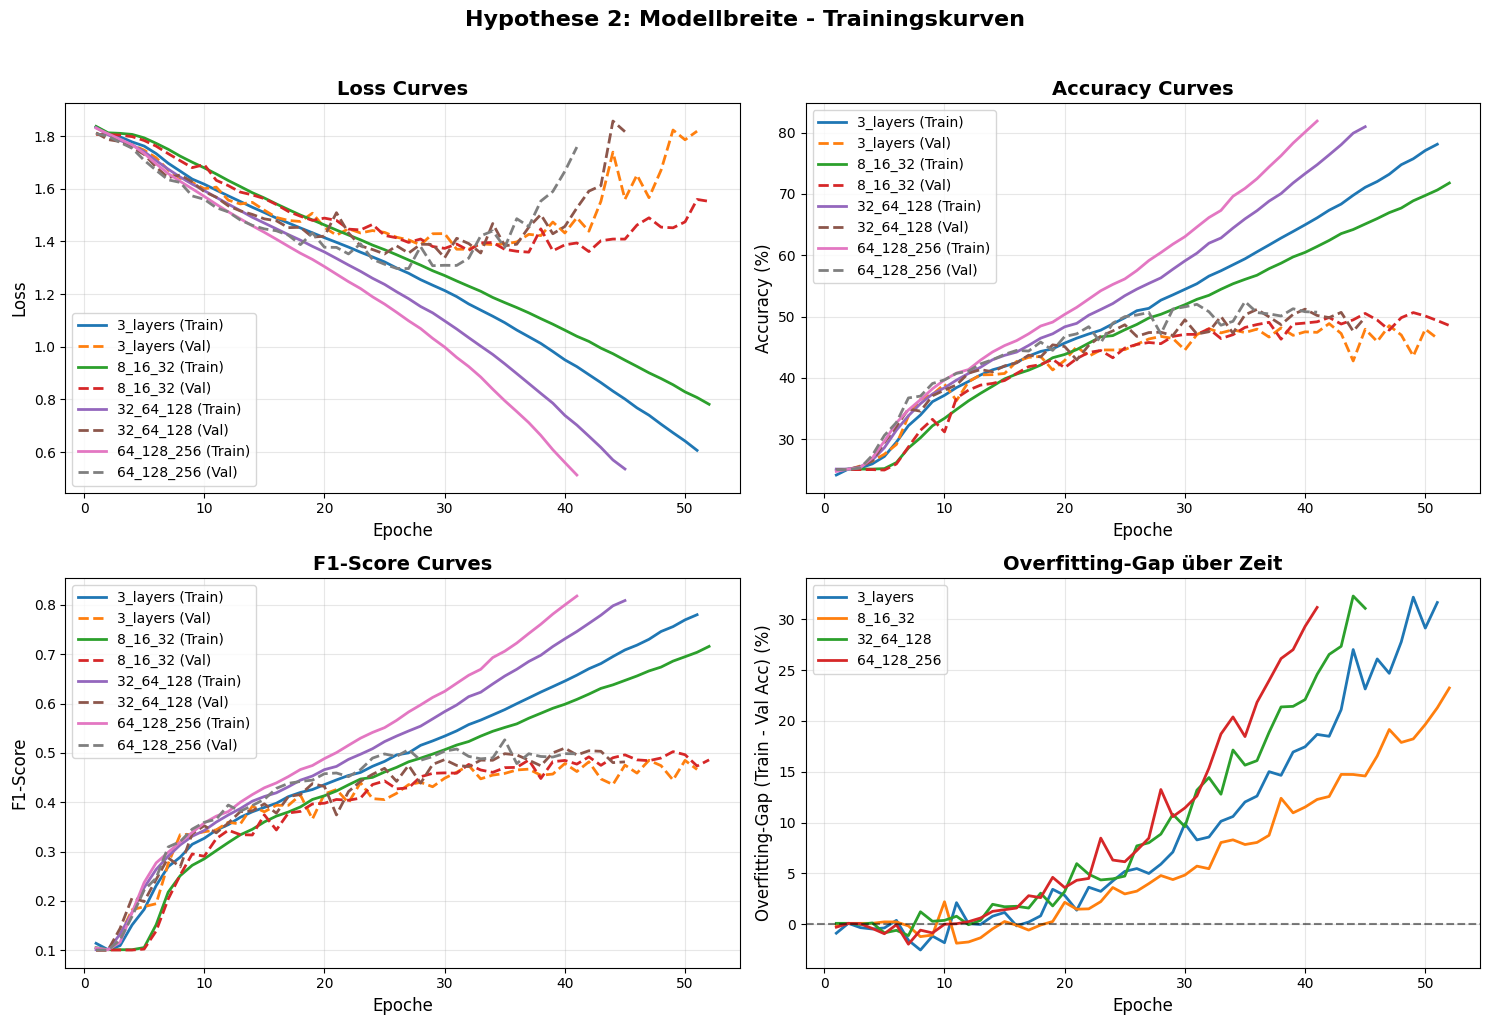

Ergebnisse gespeichert: results/hypothesis_2_width.json

Ergebnisse gespeichert: results/hypothesis_2_width.json


In [17]:
# Analyse und Visualisierung Hypothese 2
print("\n" + "="*80)
print("ANALYSE HYPOTHESE 2: MODELLBREITE")
print("="*80)

summary_data = []
for name, result in hypothesis_2_results.items():
    summary_data.append({
        'Konfiguration': name,
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung der Ergebnisse:")
print(df_summary.to_string(index=False))

# Visualisierung
fig = plot_experiment_comparison(hypothesis_2_results, metric='val_acc', 
                                 title='Hypothese 2: Modellbreite - Validation Accuracy')
plt.savefig('plots/experiments/hyp2_width_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_model_complexity_analysis(hypothesis_2_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp2_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_training_curves_comparison(hypothesis_2_results, 
                                     title='Hypothese 2: Modellbreite - Trainingskurven')
plt.savefig('plots/experiments/hyp2_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Ergebnisse speichern
save_experiment_results(hypothesis_2_results, 'results/hypothesis_2_width.json')
print("\nErgebnisse gespeichert: results/hypothesis_2_width.json")

### Hypothese 3: FC-Layer Breite (Anzahl Neuronen)

**Variiert:** Nur die FC-Layer Breite (32, 64, 128, 256, 512 Neuronen)  
**Konstant:** 3 Conv-Layer (Baseline), Filter [16, 32, 64] (Baseline)

In [18]:
# Hypothese 3 Ergebnisse initialisieren
hypothesis_3_file = 'results/hypothesis_3_fc_width.json'
hypothesis_3_results = {}

# Experiment 3.1: Baseline (3 Layer)
print("\n" + "-"*60)
print("Experiment 3.1: Baseline (3 Conv-Layer)")
print("Filter: [16, 32, 64] (Baseline)")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

# Baseline-Ergebnisse wiederverwenden
# Experiment-Name anpassen für bessere Nachverfolgbarkeit
baseline_results_hyp3 = baseline_results.copy()
baseline_results_hyp3['experiment_name'] = 'hyp3_baseline_3layers'
hypothesis_3_results['3_layers'] = baseline_results_hyp3

print(f"Baseline-Ergebnisse:")
print(f"  - Beste Val Acc: {baseline_results_hyp3['best_val_acc']:.2f}% (Epoche {baseline_results_hyp3['best_epoch']})")
print(f"  - Finale Val Acc: {baseline_results_hyp3['final_val_acc']:.2f}%")

# Automatisch speichern
save_hypothesis_results(hypothesis_3_results, hypothesis_3_file)


------------------------------------------------------------
Experiment 3.1: Baseline (3 Conv-Layer)
Filter: [16, 32, 64] (Baseline)
FC-Layer: 64 Neuronen (Baseline)
------------------------------------------------------------
Baseline-Ergebnisse:
  - Beste Val Acc: 48.87% (Epoche 42)
  - Finale Val Acc: 46.46%
Ergebnisse gespeichert: results/hypothesis_3_fc_width.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_3_fc_width.json


In [19]:
# Experiment 3.2: 32 Neuronen 
print("\n" + "-"*60)
print("Experiment 3.2: 32 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_32 = run_hyperparameter_experiment(
    experiment_name="hyp3_32_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,  
        'filters_per_layer': [16, 32, 64], 
        'fc_units': 32  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_3_results['32_units'] = result_32

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_3_results, hypothesis_3_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()


------------------------------------------------------------
Experiment 3.2: 32 Neuronen
Conv-Layer: 3 (Baseline)
Filter: [16, 32, 64] (Baseline)
------------------------------------------------------------

EXPERIMENT: hyp3_32_units
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'fc_units': 32}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 97,287 total, 97,287 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
Early Stopping: patience=15, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8317 | Val Loss: 1.8069 | Train Acc: 24.20% | Val Acc: 25.06% | Patience: 0/15
Epoch   5/60 | Train Loss: 1.7809 | Val Loss: 1.7666 | Train Acc: 25.77% | Val Acc: 25.83% | Patience: 0/15
Epoch  10/60 | Train Loss: 1.6609 | Val Loss: 1.6387 | Train Acc: 34.72% | Val Acc: 35.74% | Patience: 0/15
Epoch  15/60 | Train Loss: 1.5462 | Val Loss: 1.5511 | Train Acc: 40.66% | Val Acc: 40.06% | Patience: 0/15
Epoch  20/60 | Train Loss: 1.4352 | Val Loss: 1.4605 | Train Acc: 44.89% | Val Acc: 43.24% | Patience: 0/15
Epoch  25/60 | Train Loss: 1.3329 | Val Loss: 1.4069 | Train Acc: 49.52% | Val Acc: 45.14% | Patience: 0/15
Epoch  30/60 | Train Loss: 1.2378 | Val Loss: 1.3613 | Train Acc: 53.37% | Val Acc: 47.72% | Patience: 0/15
Epoch  35/60 | Train Loss: 1.1343 | Val Loss: 1.4227 | Train Acc: 57.72% | Val Acc: 47.00%

best_val_loss,████▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▃▃▁▁▂▃▃▄▄▅▆▆▇▇█
train_acc,▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_f1,▁▁▁▁▁▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████
train_loss,█████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁
val_acc,▁▁▁▁▁▂▃▄▄▄▄▅▅▆▆▆▇▆▇▇▇▇▇▇▇█▇██▇█▇████████
val_f1,▁▁▁▂▃▄▄▅▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇█▇▇█▇████████████
val_loss,████▇▇▆▆▅▅▅▄▄▃▃▃▂▃▂▂▁▂▂▁▁▂▂▂▁▁▁▂▂▂▂▂▃▃▃▄
best_val_loss,1.35282
epoch,51



ERGEBNISSE: hyp3_32_units
Beste Validation Accuracy: 49.65% (Epoche 50)
Finale Validation Accuracy: 49.22%
Finale Validation F1-Score: 0.4873
Overfitting-Gap (Acc): 22.55%
Test Accuracy: 0.50%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_3_fc_width.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_3_fc_width.json


33

In [20]:
# Experiment 3.3: 128 Neuronen 
print("\n" + "-"*60)
print("Experiment 3.3: 128 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_128 = run_hyperparameter_experiment(
    experiment_name="hyp3_128_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,  
        'filters_per_layer': [16, 32, 64], 
        'fc_units': 128  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32,  
    device=device,
    use_wandb=True
)
hypothesis_3_results['128_units'] = result_128

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_3_results, hypothesis_3_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()


------------------------------------------------------------
Experiment 3.3: 128 Neuronen
Conv-Layer: 3 (Baseline)
Filter: [16, 32, 64] (Baseline)
------------------------------------------------------------

EXPERIMENT: hyp3_128_units
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'fc_units': 128}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 319,239 total, 319,239 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
Early Stopping: patience=15, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8356 | Val Loss: 1.8067 | Train Acc: 24.27% | Val Acc: 25.06% | Patience: 0/15
Epoch   5/60 | Train Loss: 1.7371 | Val Loss: 1.7173 | Train Acc: 29.90% | Val Acc: 30.32% | Patience: 0/15
Epoch  10/60 | Train Loss: 1.5884 | Val Loss: 1.6022 | Train Acc: 38.66% | Val Acc: 37.29% | Patience: 0/15
Epoch  15/60 | Train Loss: 1.4732 | Val Loss: 1.4912 | Train Acc: 43.48% | Val Acc: 41.78% | Patience: 0/15
Epoch  20/60 | Train Loss: 1.3597 | Val Loss: 1.4223 | Train Acc: 48.00% | Val Acc: 45.75% | Patience: 0/15
Epoch  25/60 | Train Loss: 1.2306 | Val Loss: 1.3760 | Train Acc: 53.42% | Val Acc: 47.32% | Patience: 0/15
Epoch  30/60 | Train Loss: 1.0777 | Val Loss: 1.3726 | Train Acc: 60.18% | Val Acc: 48.87% | Patience: 0/15
Epoch  35/60 | Train Loss: 0.8959 | Val Loss: 1.5055 | Train Acc: 67.62% | Val Acc: 46.62%

best_val_loss,██▇▇▇▆▅▅▅▄▄▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▁▁▂▂▃▃▄▅▅▆▆▇▇█
train_acc,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
train_f1,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█████▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
val_acc,▁▁▁▂▂▃▄▅▄▅▅▆▅▆▅▆▆▇▇▇▇▇▇▇▇▇█▇▇██▇▇▇██████
val_f1,▁▁▂▃▃▄▅▅▅▆▅▆▆▆▅▆▆▇▇▇▇▇▇▇█▇██████████████
val_loss,▅▅▅▅▄▄▄▃▃▃▃▂▂▂▃▂▂▁▁▁▁▁▁▂▁▂▁▂▂▂▂▂▃▃▃▄▅▅▆█
best_val_loss,1.37258
epoch,45



ERGEBNISSE: hyp3_128_units
Beste Validation Accuracy: 49.86% (Epoche 39)
Finale Validation Accuracy: 49.53%
Finale Validation F1-Score: 0.4789
Overfitting-Gap (Acc): 34.97%
Test Accuracy: 0.49%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_3_fc_width.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_3_fc_width.json


33

In [21]:
# Experiment 3.4: 256 Neuronen
print("\n" + "-"*60)
print("Experiment 3.4: 256 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_256 = run_hyperparameter_experiment(
    experiment_name="hyp3_256_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3, 
        'filters_per_layer': [16, 32, 64],
        'fc_units': 256  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_3_results['256_units'] = result_256

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_3_results, hypothesis_3_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()


------------------------------------------------------------
Experiment 3.4: 256 Neuronen
Conv-Layer: 3 (Baseline)
Filter: [16, 32, 64] (Baseline)
------------------------------------------------------------

EXPERIMENT: hyp3_256_units
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'fc_units': 256}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 615,175 total, 615,175 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
Early Stopping: patience=15, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8307 | Val Loss: 1.8105 | Train Acc: 24.97% | Val Acc: 25.06% | Patience: 0/15
Epoch   5/60 | Train Loss: 1.7939 | Val Loss: 1.7835 | Train Acc: 25.19% | Val Acc: 25.71% | Patience: 0/15
Epoch  10/60 | Train Loss: 1.6713 | Val Loss: 1.6491 | Train Acc: 34.45% | Val Acc: 35.68% | Patience: 0/15
Epoch  15/60 | Train Loss: 1.5436 | Val Loss: 1.5590 | Train Acc: 40.86% | Val Acc: 39.22% | Patience: 0/15
Epoch  20/60 | Train Loss: 1.4286 | Val Loss: 1.4593 | Train Acc: 45.30% | Val Acc: 43.33% | Patience: 0/15
Epoch  25/60 | Train Loss: 1.3023 | Val Loss: 1.4431 | Train Acc: 50.66% | Val Acc: 44.97% | Patience: 2/15
Epoch  30/60 | Train Loss: 1.1442 | Val Loss: 1.4411 | Train Acc: 57.50% | Val Acc: 45.58% | Patience: 7/15
Epoch  35/60 | Train Loss: 0.9298 | Val Loss: 1.5343 | Train Acc: 66.08% | Val Acc: 45.51%

best_val_loss,████▇▇▇▆▅▅▄▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_acc,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
train_f1,▁▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
train_loss,███████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▁▁
val_acc,▁▁▁▁▁▂▂▃▄▄▄▅▅▅▅▅▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇█
val_f1,▁▁▁▁▂▃▃▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
val_loss,████▇▇▇▆▅▅▄▄▄▄▃▃▂▂▂▁▂▂▁▁▁▁▁▂▂▁▁▂▂▂▃▃▄▅
best_val_loss,1.43783
epoch,38



ERGEBNISSE: hyp3_256_units
Beste Validation Accuracy: 47.82% (Epoche 38)
Finale Validation Accuracy: 47.82%
Finale Validation F1-Score: 0.4651
Overfitting-Gap (Acc): 24.28%
Test Accuracy: 0.48%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_3_fc_width.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_3_fc_width.json


33

In [22]:
# Experiment 3.5: 512 Neuronen
print("\n" + "-"*60)
print("Experiment 3.5: 512 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_512 = run_hyperparameter_experiment(
    experiment_name="hyp3_512_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64], 
        'fc_units': 512  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 
    device=device,
    use_wandb=True
)
hypothesis_3_results['512_units'] = result_512

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_3_results, hypothesis_3_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()


------------------------------------------------------------
Experiment 3.5: 512 Neuronen
Conv-Layer: 3 (Baseline)
Filter: [16, 32, 64] (Baseline)
------------------------------------------------------------

EXPERIMENT: hyp3_512_units
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'fc_units': 512}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 1,207,047 total, 1,207,047 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
Early Stopping: patience=15, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8309 | Val Loss: 1.8050 | Train Acc: 24.99% | Val Acc: 25.06% | Patience: 0/15
Epoch   5/60 | Train Loss: 1.7443 | Val Loss: 1.7256 | Train Acc: 29.41% | Val Acc: 30.30% | Patience: 0/15
Epoch  10/60 | Train Loss: 1.5814 | Val Loss: 1.5702 | Train Acc: 38.99% | Val Acc: 38.49% | Patience: 0/15
Epoch  15/60 | Train Loss: 1.4591 | Val Loss: 1.4736 | Train Acc: 44.05% | Val Acc: 42.06% | Patience: 0/15
Epoch  20/60 | Train Loss: 1.3309 | Val Loss: 1.4013 | Train Acc: 49.56% | Val Acc: 45.42% | Patience: 0/15
Epoch  25/60 | Train Loss: 1.1694 | Val Loss: 1.3903 | Train Acc: 56.40% | Val Acc: 47.49% | Patience: 2/15
Epoch  30/60 | Train Loss: 0.9385 | Val Loss: 1.4910 | Train Acc: 65.82% | Val Acc: 46.80% | Patience: 4/15
Epoch  35/60 | Train Loss: 0.6276 | Val Loss: 1.7057 | Train Acc: 77.66% | Val Acc: 45.44%

best_val_loss,███▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_acc,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
train_f1,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
train_loss,█████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▁▁
val_acc,▁▁▁▂▃▃▄▄▅▅▆▅▆▆▆▆▆▆▇▇▆▆▇▇████▇▇████▇█████
val_f1,▁▁▁▂▄▄▅▅▅▅▆▅▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇▇▇████▇█▇███
val_loss,▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▂▂▂▂▂▃▄▄▅▆▆█
best_val_loss,1.36217
epoch,41



ERGEBNISSE: hyp3_512_units
Beste Validation Accuracy: 49.34% (Epoche 40)
Finale Validation Accuracy: 47.68%
Finale Validation F1-Score: 0.4858
Overfitting-Gap (Acc): 43.86%
Test Accuracy: 0.49%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_3_fc_width.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_3_fc_width.json


33


ANALYSE HYPOTHESE 3: FC-LAYER BREITE

Zusammenfassung der Ergebnisse:
Konfiguration Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
     3_layers   171,271             48.87              46.46               31.64
     32_units    97,287             49.65              49.22               22.55
    128_units   319,239             49.86              49.53               34.97
    256_units   615,175             47.82              47.82               24.28
    512_units 1,207,047             49.34              47.68               43.86


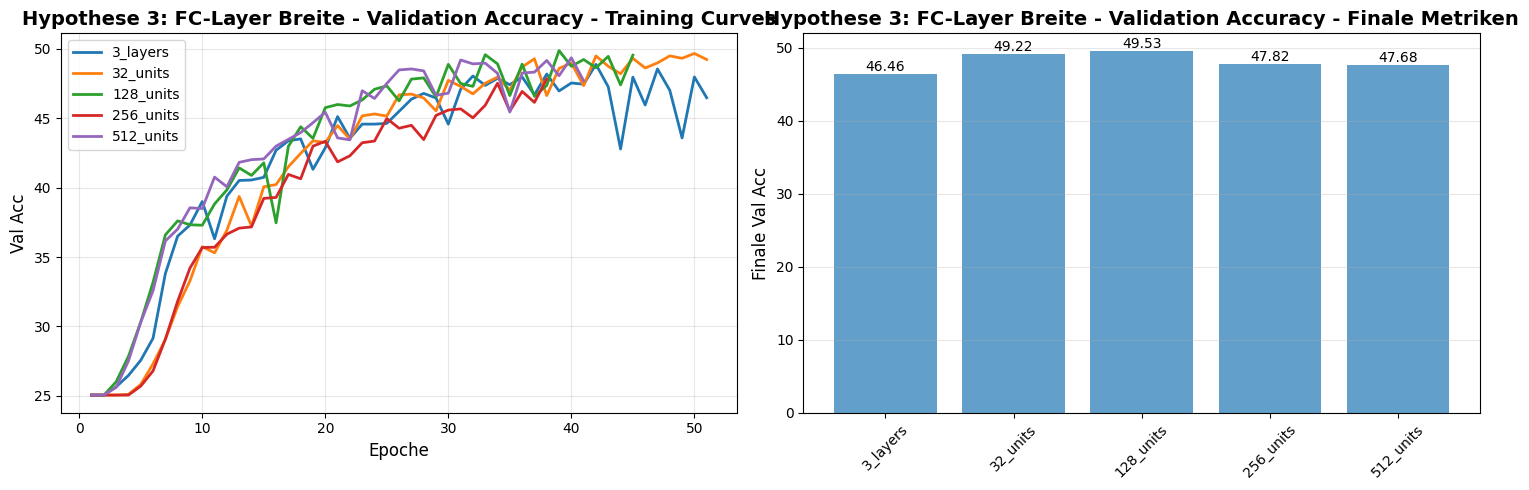

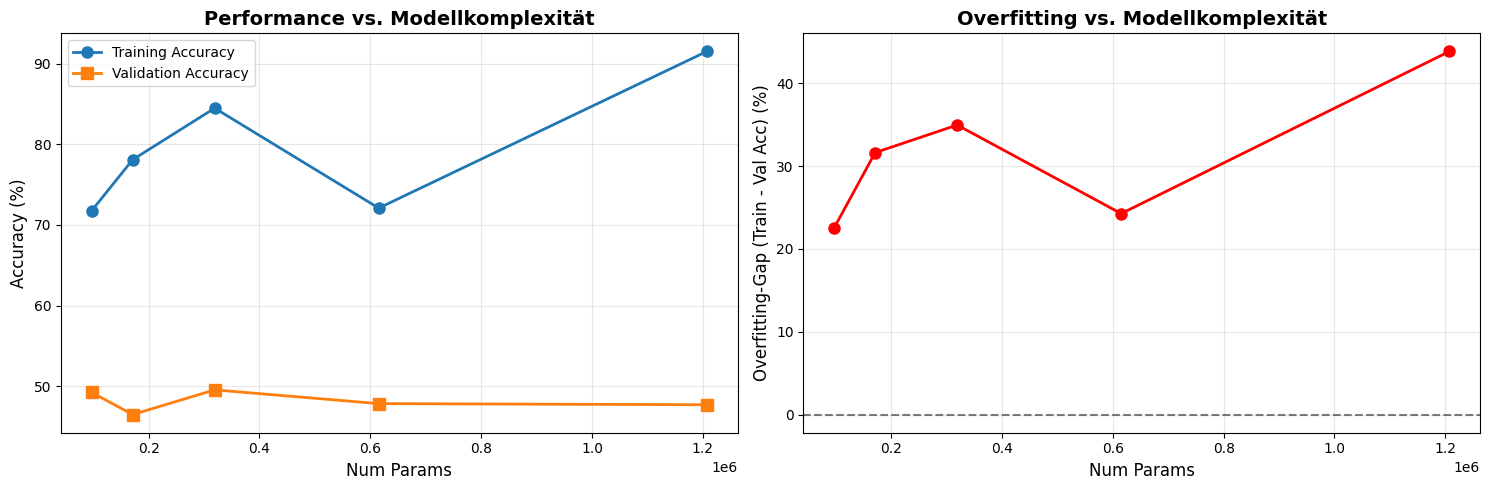

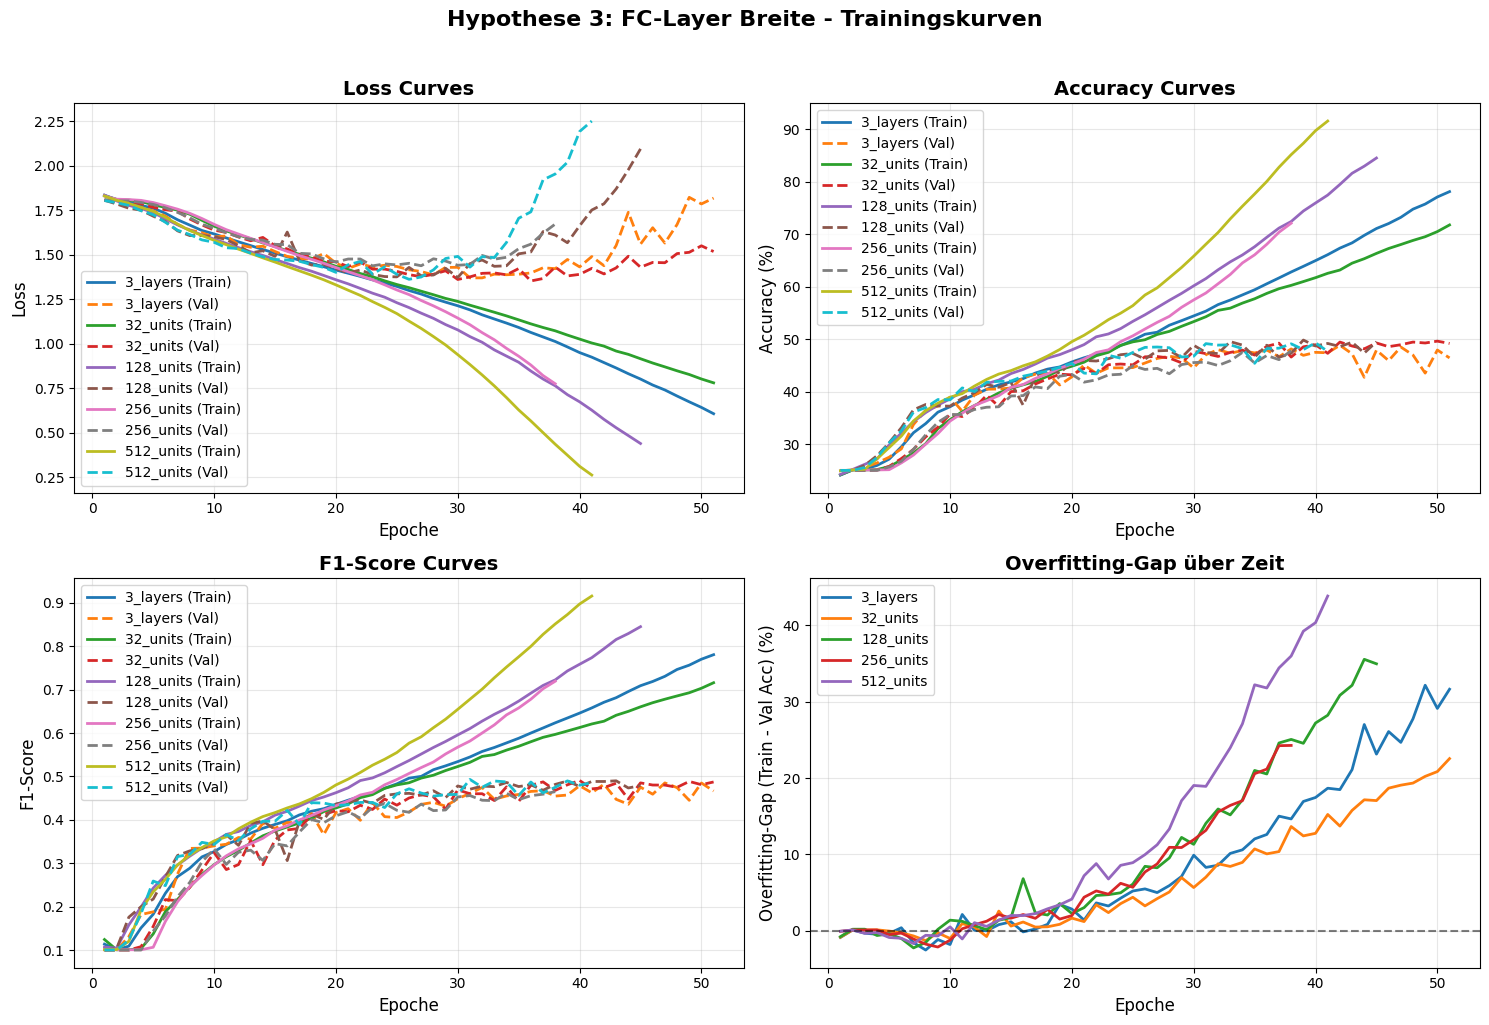

Ergebnisse gespeichert: results/hypothesis_3_fc_width.json

Ergebnisse gespeichert: results/hypothesis_3_fc_width.json


In [23]:
# Analyse und Visualisierung Hypothese 3
print("\n" + "="*80)
print("ANALYSE HYPOTHESE 3: FC-LAYER BREITE")
print("="*80)

summary_data = []
for name, result in hypothesis_3_results.items():
    summary_data.append({
        'Konfiguration': name,
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung der Ergebnisse:")
print(df_summary.to_string(index=False))

# Visualisierung
fig = plot_experiment_comparison(hypothesis_3_results, metric='val_acc', 
                                 title='Hypothese 3: FC-Layer Breite - Validation Accuracy')
plt.savefig('plots/experiments/hyp3_fc_width_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_model_complexity_analysis(hypothesis_3_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp3_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_training_curves_comparison(hypothesis_3_results, 
                                     title='Hypothese 3: FC-Layer Breite - Trainingskurven')
plt.savefig('plots/experiments/hyp3_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Ergebnisse speichern
save_experiment_results(hypothesis_3_results, 'results/hypothesis_3_fc_width.json')
print("\nErgebnisse gespeichert: results/hypothesis_3_fc_width.json")

### Zusammenfassung Kategorie 1

ZUSAMMENFASSUNG: KATEGORIE 1 - MODELLKOMPLEXITÄT

Beste Konfigurationen pro Hypothese:
Hypothese             Konfiguration Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
Hyp1_Best              hyp1_4layers   171,399             50.70              49.56               30.50
Hyp2_Best hyp2_very_wide_64_128_256   960,007             52.46              50.73               31.16
Hyp3_Best            hyp3_128_units   319,239             49.86              49.53               34.97

GESAMTBESTE KONFIGURATION: Hyp2_Best
Experiment: hyp2_very_wide_64_128_256
Beste Validation Accuracy: 52.46%
Finale Validation Accuracy: 50.73%
Overfitting-Gap: 31.16%
Modell-Parameter: 960,007


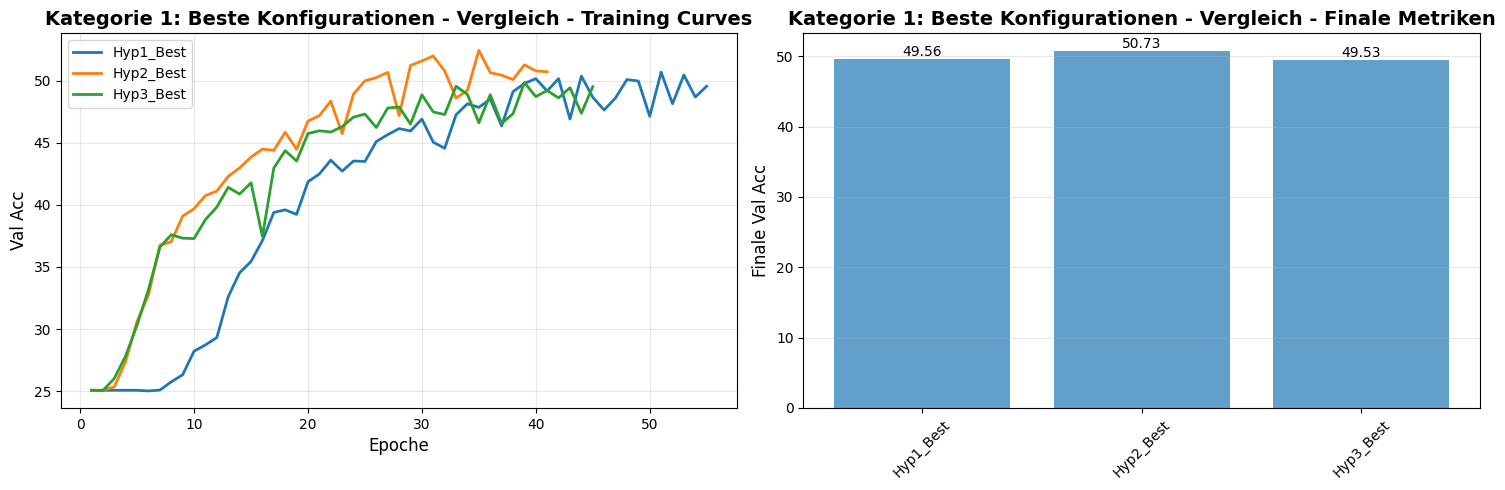

Ergebnisse gespeichert: results/category1_all_results.json

Alle Ergebnisse gespeichert: results/category1_all_results.json


In [24]:
# Zusammenfassung aller Experimente
print("="*80)
print("ZUSAMMENFASSUNG: KATEGORIE 1 - MODELLKOMPLEXITÄT")
print("="*80)

# Beste Konfigurationen aus jeder Hypothese
best_hyp1 = max(hypothesis_1_results.keys(), 
                key=lambda k: hypothesis_1_results[k]['best_val_acc'])
best_hyp2 = max(hypothesis_2_results.keys(), 
                key=lambda k: hypothesis_2_results[k]['best_val_acc'])
best_hyp3 = max(hypothesis_3_results.keys(), 
                key=lambda k: hypothesis_3_results[k]['best_val_acc'])

summary_all = {
    'Hyp1_Best': hypothesis_1_results[best_hyp1],
    'Hyp2_Best': hypothesis_2_results[best_hyp2],
    'Hyp3_Best': hypothesis_3_results[best_hyp3]
}

# Vergleichstabelle
comparison_data = []
for name, result in summary_all.items():
    comparison_data.append({
        'Hypothese': name,
        'Konfiguration': result['experiment_name'],
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nBeste Konfigurationen pro Hypothese:")
print(df_comparison.to_string(index=False))

# Gesamtbeste Konfiguration
overall_best = max(summary_all.keys(), 
                  key=lambda k: summary_all[k]['best_val_acc'])
overall_best_result = summary_all[overall_best]

print(f"\n{'='*80}")
print(f"GESAMTBESTE KONFIGURATION: {overall_best}")
print(f"{'='*80}")
print(f"Experiment: {overall_best_result['experiment_name']}")
print(f"Beste Validation Accuracy: {overall_best_result['best_val_acc']:.2f}%")
print(f"Finale Validation Accuracy: {overall_best_result['final_val_acc']:.2f}%")
print(f"Overfitting-Gap: {overall_best_result['overfitting_gap_acc']:.2f}%")
print(f"Modell-Parameter: {overall_best_result['num_params']:,}")

# Visualisierung aller besten Konfigurationen
fig = plot_experiment_comparison(summary_all, metric='val_acc', 
                                 title='Kategorie 1: Beste Konfigurationen - Vergleich')
plt.savefig('plots/experiments/category1_best_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Alle Ergebnisse speichern
all_results = {
    'hypothesis_1': hypothesis_1_results,
    'hypothesis_2': hypothesis_2_results,
    'hypothesis_3': hypothesis_3_results,
    'summary': {
        'best_hyp1': best_hyp1,
        'best_hyp2': best_hyp2,
        'best_hyp3': best_hyp3,
        'overall_best': overall_best
    }
}

save_experiment_results(all_results, 'results/category1_all_results.json')
print("\nAlle Ergebnisse gespeichert: results/category1_all_results.json")